# Mobile Price Prediction
**Goal:** predict mobile phone prices and identify the most influential features.

This notebook:
- Performs **data cleaning & preprocessing first** (imputations, winsorizing, encoding).
- Then performs EDA (univariate, bivariate, multivariate).
- Runs feature extraction (correlation, SelectKBest, mutual information, RF importances).
- Builds and evaluates models (Linear Regression, Random Forest, Gradient Boosting).
- Saves plots, CSV outputs, models, and a short markdown report.


In [1]:
# Cell 2 (Code) - Setup and imports
import os
import re
import tempfile
import logging
from datetime import datetime
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from openpyxl import load_workbook
from openpyxl.styles import Alignment, Font, PatternFill, Border, Side
from openpyxl.drawing.image import Image as XLImage
from openpyxl.utils import get_column_letter
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.chart import BarChart, Reference
from openpyxl.chart.label import DataLabelList
from tempfile import NamedTemporaryFile
import matplotlib.pyplot as plt
from io import BytesIO
import time, psutil, shutil
import seaborn as sns
import joblib
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rcParams['figure.dpi'] = 120

# Output directories
OUTPUT_DIR = './mobile_price_notebook_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
PLOTS_DIR = os.path.join(OUTPUT_DIR, 'plots')
os.makedirs(PLOTS_DIR, exist_ok=True)
LOG_PATH = os.path.join(OUTPUT_DIR, 'notebook.log')

# Setup logger
logger = logging.getLogger('mobile_price_notebook')
logger.setLevel(logging.DEBUG)
if logger.handlers:
    logger.handlers.clear()
fh = logging.FileHandler(LOG_PATH)
fh.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

logger.info('Starting notebook run at %s', datetime.utcnow().isoformat())

# Utilities
def save_fig(fig, path):
    fig.savefig(path, bbox_inches='tight')
    plt.close(fig)
    logger.debug(f'Saved figure: {path}')

def metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': math.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

C:\Users\Aishwarya Kr Singh\AppData\Local\Temp\ipykernel_23896\76411558.py:64: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  logger.info('Starting notebook run at %s', datetime.utcnow().isoformat())
2025-11-16 00:07:36,933 - INFO - Starting notebook run at 2025-11-15T18:37:36.933691


## Load data & initial inspection
Update DATA_PATH for file recognition. This helps in reading the file data at a particular location.



In [2]:
# Define the path to your dataset
DATA_PATH = "./Processed_Flipdata.xlsx"

# Try reading the Excel file
try:
    # Specify engine explicitly to avoid "No such keys(s): 'io.excel.zip.reader'"
    df = pd.read_excel(DATA_PATH, engine='openpyxl')
    print("Data Loaded Successfully!")
    logger.info(f"Loaded dataset: {df.shape}")
    display(df.head())

except FileNotFoundError:
    print("Error: File not found. Please check the DATA_PATH.")
except ImportError:
    print("Missing dependency: Please install openpyxl by running:")
    print("   pip install -U openpyxl")
except Exception as e:
    print("An error occurred while loading the file:")
    print(e)

2025-11-16 00:07:37,141 - INFO - Loaded dataset: (541, 12)


Data Loaded Successfully!


,Unnamed: 0,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Prize
0,0,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,1,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,2,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,11999
3,3,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,5649
4,4,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,8999


## Preview Data Set
Here we will be using head() and tail() methods to preview the data. These functions help us in inspecting the first and last few rows of the dataset. This will give idea about the nature off  the data set  and will help in prediction and conclusion(s).


In [3]:
# View rows from top/starting of the dataset
df.head()

,Unnamed: 0,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Prize
0,0,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,1,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,2,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,11999
3,3,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,5649
4,4,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,8999


In [4]:
# View rows from bottom/ending of the dataset
df.tail()

,Unnamed: 0,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,AI Lens,Mobile Height,Processor_,Prize
536,637,SAMSUNG Galaxy S23 5G,Cream,256,8,3900,50MP,12MP,0,15.49,Qualcomm Snapdragon 8 Gen 2,79999
537,638,LAVA Z21,Cyan,32,2,3100,5MP,2MP,0,12.70,Octa Core,5998
538,639,Tecno Spark 8T,Turquoise Cyan,64,4,5000,50MP,8MP,0,16.76,MediaTek Helio G35,9990
539,641,SAMSUNG Galaxy A54 5G,Awesome Lime,128,8,5000,50MP,32MP,0,16.26,"Exynos 1380, Octa Core",38999
540,642,OPPO A77,Sky Blue,128,4,5000,50MP,8MP,0,16.66,Mediatek Helio G35,15999


## Dataset Summary before data cleaning

The `info()` method reveals:
- Column names
- Data types
- Non-null counts

In [5]:
# Get the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     541 non-null    int64  
 1   Model          541 non-null    object 
 2   Colour         541 non-null    object 
 3   Memory         541 non-null    int64  
 4   RAM            541 non-null    int64  
 5   Battery_       541 non-null    int64  
 6   Rear Camera    541 non-null    object 
 7   Front Camera   541 non-null    object 
 8   AI Lens        541 non-null    int64  
 9   Mobile Height  541 non-null    float64
 10  Processor_     541 non-null    object 
 11  Prize          541 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 50.8+ KB


## Standardize Column names

In [6]:
# Standardize column names and detect target column

df.columns = [c.strip() for c in df.columns]
logger.info(f"Columns standardized: {df.columns.tolist()}")

possible_targets = [c for c in df.columns if 'price' in c.lower() or 'priz' in c.lower()]
if not possible_targets:
    numeric_cols_tmp = df.select_dtypes(include=[np.number]).columns.tolist()
    ranges = {c: (df[c].max() - df[c].min()) for c in numeric_cols_tmp}
    possible_targets = [max(ranges, key=ranges.get)]

TARGET = possible_targets[0]
logger.info(f"Detected target column: {TARGET}")

df[TARGET] = pd.to_numeric(df[TARGET], errors='coerce')

before_rows = df.shape[0]
df = df[df[TARGET].notnull()].reset_index(drop=True)
logger.info(f"Dropped {before_rows - df.shape[0]} rows missing target")

2025-11-16 00:07:37,265 - INFO - Columns standardized: ['Unnamed: 0', 'Model', 'Colour', 'Memory', 'RAM', 'Battery_', 'Rear Camera', 'Front Camera', 'AI Lens', 'Mobile Height', 'Processor_', 'Prize']
2025-11-16 00:07:37,268 - INFO - Detected target column: Prize
2025-11-16 00:07:37,272 - INFO - Dropped 0 rows missing target


## Save Cleaned Data to the same workbook in a new worksheet
This helps in getting the data updated in the same workbook to compare with the original dataset.

This cell checks if Microsoft Excel is running in the background.
If open, saving the workbook can fail with "Permission denied" errors.
We simply warn the user.

In [7]:
# ===========================
# Warn if Excel is open
# ===========================
for p in psutil.process_iter():
    if "EXCEL" in p.name().upper():
        logger.warning("Excel appears to be open. Please close it before continuing to avoid save errors.")

We load the Excel workbook and create (or recreate) a clean sheet named Cleaned Processed Flip Data.
If an old sheet exists, it is deleted.

In [8]:
# ===========================
# Load Workbook and Create Sheet
# ===========================
wb = load_workbook(DATA_PATH)

# Remove existing cleaned sheet if it already exists
if 'Cleaned Processed Flip Data' in wb.sheetnames:
    del wb['Cleaned Processed Flip Data']

ws = wb.create_sheet('Cleaned Processed Flip Data')

This cell defines a helper function to clean column names:

- Trim spaces

- Replace special characters

- Convert to Title_Case_With_Underscores.
  This ensures cleaner metadata and consistent formatting in Excel.

In [9]:
# ===========================
# Clean and Standardize Column Names
# ===========================
def clean_column_name(col):
    """Standardize column names: strip, replace spaces/special chars, use underscores."""
    col = str(col).strip()
    col = col.replace('-', ' ').replace('.', ' ').replace('/', ' ')
    col = "_".join(col.split())
    return col.title().replace("_", "_")

This cell:

- Removes unwanted "Unnamed: 0" column

- Applies cleaned column names

- Removes duplicate column names (case-insensitive)

- Ensures a single Record_Id column

In [10]:
# ===========================
# Initial Cleanup — remove unwanted columns like 'Unnamed: 0'
# ===========================
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Apply cleaning to all column names
df.columns = [clean_column_name(c) for c in df.columns]

# Remove duplicate column names (case-insensitive)
df = df.loc[:, ~df.columns.str.lower().duplicated()]

# Ensure a single "Record_Id" column (case-insensitive)
df = df[[c for c in df.columns if c.lower() != 'record_id']]

# Rebuild the DataFrame to drop any hidden duplicate column blocks
df = df.copy()

We reset the index to start from 1, then rename it to `Record_Id`.
This provides a clean serial number for each row.

In [11]:
# ===========================
# Prepare Record_Id column starting from 1
# ===========================
df.reset_index(drop=True, inplace=True)
df.index += 1
df.reset_index(inplace=True)
df.rename(columns={'index': 'Record_Id'}, inplace=True)

Convert the DataFrame to rows and append to the Excel sheet.

In [12]:
# ===========================
# Write DataFrame to Sheet
# ===========================
for r in dataframe_to_rows(df, index=False, header=True):
    ws.append(r)

Define all the styling used later:

- Header background

- First column styling

- Borders

- Center alignment

In [13]:
# ===========================
# Define Styles
# ===========================
header_fill = PatternFill(start_color='003366', end_color='003366', fill_type='solid')   # Dark Blue
firstcol_fill = PatternFill(start_color='336699', end_color='336699', fill_type='solid') # Lighter Blue
font_white_bold = Font(color='FFFFFF', bold=True)
align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
border_style = Border(
    left=Side(style='thin', color='000000'),
    right=Side(style='thin', color='000000'),
    top=Side(style='thin', color='000000'),
    bottom=Side(style='thin', color='000000')
)

Apply dark blue background, white bold font, alignment, and borders to header.

In [14]:
# ===========================
# Apply Header Style
# ===========================
for cell in ws[1]:
    cell.fill = header_fill
    cell.font = font_white_bold
    cell.alignment = align_center
    cell.border = border_style

The first column gets a lighter blue fill to highlight the ID column

In [15]:
# ===========================
# Apply Record_Id (first column) Style
# ===========================
for row in ws.iter_rows(min_row=2, min_col=1, max_col=1):
    for cell in row:
        cell.fill = firstcol_fill
        cell.font = font_white_bold
        cell.alignment = align_center
        cell.border = border_style

Ensures uniform look across the entire sheet.

In [16]:
# ===========================
# Apply Border + Center Alignment to All Cells
# ===========================
for row in ws.iter_rows():
    for cell in row:
        cell.border = border_style
        cell.alignment = align_center

Automatically adjusts column widths based on the maximum text length in each column.

In [17]:
# ===========================
# Auto-adjust Column Widths
# ===========================
for col in ws.columns:
    max_length = 0
    column = col[0].column_letter  # Get column letter (A, B, C, ...)
    for cell in col:
        try:
            cell_value = str(cell.value) if cell.value is not None else ""
            if len(cell_value) > max_length:
                max_length = len(cell_value)
        except:
            pass
    ws.column_dimensions[column].width = max_length + 2  # Add small padding

Freeze panes so header row and Record_Id are always visible.

In [18]:
# ===========================
# Freeze header + first column
# ===========================
ws.freeze_panes = 'B2'

This cell:

- Kills lingering Excel processes

- Saves workbook safely in a temporary file

- Replaces original workbook

- Logs success / errors

In [19]:
# ===========================
# Safe Save (Avoid Locked File Issues)
# ===========================

# Kill any stray Excel processes
for p in psutil.process_iter():
    if "EXCEL" in p.name().upper():
        p.kill()
        print("Killed lingering Excel process to unlock file.")

try:
    with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
        temp_filename = tmp.name
        wb.save(temp_filename)
    wb.close()

    time.sleep(1)  # short pause to ensure file handle release
    shutil.move(temp_filename, DATA_PATH)
    logger.info(f"Workbook successfully saved to {DATA_PATH}")

except PermissionError:
    logger.error("Excel or another process still has the file locked. Please close all Excel windows and try again.")
except Exception as e:
    logger.error(f"Unexpected error while saving workbook: {e}")

logger.info(f"Final df columns: {list(df.columns)}")

2025-11-16 00:07:41,308 - INFO - Workbook successfully saved to ./Processed_Flipdata.xlsx
2025-11-16 00:07:41,310 - INFO - Final df columns: ['Record_Id', 'Model', 'Colour', 'Memory', 'Ram', 'Battery_', 'Rear_Camera', 'Front_Camera', 'Ai_Lens', 'Mobile_Height', 'Processor_', 'Prize']


## Exploratory Data Analysis(EDA)
In this part, we will perform and got through multiple operations to clean the data set and generate some useful insights from the data. This helps in predicting the mobile device prices. We will consider the following points:
- Data Overview
- Data Quality Checks
- Missing Value Treatment
- Feature Summary & Statistics
- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis
- Outlier Detection
- Feature Relationships & Insights
- Data Distribution & Balance
- Summary & Next Steps


### Data Overview
- head() - displays the first 5 rows
- tail() - displays the last 5 rows
- info() - reveals column names, data types, and non-null counts

In [20]:
df.head()

,Record_Id,Model,Colour,Memory,Ram,Battery_,Rear_Camera,Front_Camera,Ai_Lens,Mobile_Height,Processor_,Prize
0,1,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,2,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,3,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,11999
3,4,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,5649
4,5,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,8999


In [21]:
df.tail()

,Record_Id,Model,Colour,Memory,Ram,Battery_,Rear_Camera,Front_Camera,Ai_Lens,Mobile_Height,Processor_,Prize
536,537,SAMSUNG Galaxy S23 5G,Cream,256,8,3900,50MP,12MP,0,15.49,Qualcomm Snapdragon 8 Gen 2,79999
537,538,LAVA Z21,Cyan,32,2,3100,5MP,2MP,0,12.70,Octa Core,5998
538,539,Tecno Spark 8T,Turquoise Cyan,64,4,5000,50MP,8MP,0,16.76,MediaTek Helio G35,9990
539,540,SAMSUNG Galaxy A54 5G,Awesome Lime,128,8,5000,50MP,32MP,0,16.26,"Exynos 1380, Octa Core",38999
540,541,OPPO A77,Sky Blue,128,4,5000,50MP,8MP,0,16.66,Mediatek Helio G35,15999


In [22]:
# Get the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Record_Id      541 non-null    int64  
 1   Model          541 non-null    object 
 2   Colour         541 non-null    object 
 3   Memory         541 non-null    int64  
 4   Ram            541 non-null    int64  
 5   Battery_       541 non-null    int64  
 6   Rear_Camera    541 non-null    object 
 7   Front_Camera   541 non-null    object 
 8   Ai_Lens        541 non-null    int64  
 9   Mobile_Height  541 non-null    float64
 10  Processor_     541 non-null    object 
 11  Prize          541 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 50.8+ KB


### Data Quality Checks
- Identify missing/null values per column
- Calculate missing value percentages
- Detect and review duplicate rows
- Check for inconsistent or invalid values

#### Missing Value Analysis & Treatment

In [23]:
from openpyxl.utils import get_column_letter

# ===========================
# Create Missing Value Analysis Sheet
# ===========================
sheet_name = "Missing Value Analysis"

# Remove sheet if it already exists
if sheet_name in wb.sheetnames:
    del wb[sheet_name]

ws_mv = wb.create_sheet(sheet_name)

# ===========================
# Compute missing values
# ===========================
missing_values = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).round(2)

missing_summary = pd.DataFrame({
    'Column Name': missing_values.index,
    'Missing Values': missing_values.values,
    'Percentage (%)': missing_percent.values
}).sort_values(by='Missing Values', ascending=False)

# ===========================
# Create top merged header
# ===========================
max_col = missing_summary.shape[1]  # number of columns in table
header_text = "Missing Value Analysis"

ws_mv.merge_cells(start_row=1, start_column=1, end_row=2, end_column=max_col)
top_cell = ws_mv.cell(row=1, column=1)
top_cell.value = header_text

# Style the top header
top_cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')
top_cell.font = Font(color='FFFFFF', bold=True)
top_cell.alignment = Alignment(horizontal='center', vertical='center')

# ===========================
# Write table headers
# ===========================
for col_idx, col_name in enumerate(missing_summary.columns, start=1):
    cell = ws_mv.cell(row=3, column=col_idx)
    cell.value = col_name
    cell.fill = PatternFill(start_color='003366', end_color='003366', fill_type='solid')
    cell.font = Font(color='FFFFFF', bold=True)
    cell.alignment = Alignment(horizontal='center', vertical='center')
    cell.border = border_style

# ===========================
# Write table data
# ===========================
for r_idx, row in enumerate(missing_summary.itertuples(index=False), start=4):
    for c_idx, value in enumerate(row, start=1):
        cell = ws_mv.cell(row=r_idx, column=c_idx)
        cell.value = value
        cell.alignment = align_center
        cell.border = border_style

# ===========================
# Auto-adjust column widths
# ===========================
for col_idx in range(1, max_col+1):
    max_length = 0
    col_letter = get_column_letter(col_idx)
    for cell in ws_mv[col_letter]:
        try:
            cell_value = str(cell.value) if cell.value is not None else ""
            if len(cell_value) > max_length:
                max_length = len(cell_value)
        except:
            pass
    ws_mv.column_dimensions[col_letter].width = max_length + 2  # small padding

# ===========================
# Freeze top 3 rows
# ===========================
ws_mv.freeze_panes = 'A4'


for p in psutil.process_iter():
    if "EXCEL" in p.name().upper():
        p.kill()
        logger.info("Terminated lingering Excel process.")
# ===========================
# Safe Save (Final Version)
# ===========================
import time

# Kill background Excel processes if still open
for p in psutil.process_iter():
    if "EXCEL" in p.name().upper():
        p.kill()
        logger.info("Terminated lingering Excel process.")

try:
    with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
        temp_filename = tmp.name
        wb.save(temp_filename)
    wb.close()

    time.sleep(0.5)  # ensure file handle release
    shutil.move(temp_filename, DATA_PATH)

    logger.info("Workbook saved with Missing Value Analysis sheet.")

except PermissionError:
    logger.error("Please close the Excel file and try again.")
except Exception as e:
    logger.error(f"Unexpected error while saving workbook: {e}")

2025-11-16 00:07:41,881 - ERROR - Unexpected error while saving workbook: I/O operation on closed file.


In [24]:
# Step 3: Winsorize Numeric Columns
from scipy.stats.mstats import winsorize

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Winsorization
for col in numeric_cols:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])

logger.info('Winsorization applied.')

2025-11-16 00:07:41,907 - INFO - Winsorization applied.


#### Removing the duplicate entries 

In [25]:
# ===========================
# Detect and Export Duplicate Records
# ===========================

# Find duplicates (excluding the index)
duplicate_mask = df.duplicated(keep=False)   # keep=False → marks all duplicates
duplicates_df = df[duplicate_mask].copy()

# Report count
logger.info(f"Total duplicate rows found: {duplicates_df.shape[0]}")

# Show sample duplicates
if not duplicates_df.empty:
    logger.info("Sample duplicate rows:")
    display(duplicates_df.head(10))
else:
    logger.info("No duplicate rows found in the dataset.")

# (Optional) Save duplicates to a separate Excel sheet
if not duplicates_df.empty:
    wb = load_workbook(DATA_PATH)

    # Remove existing 'Duplicate Records' sheet if it exists
    if 'Duplicate Records' in wb.sheetnames:
        del wb['Duplicate Records']

    ws_dup = wb.create_sheet('Duplicate Records')

    # Write duplicates DataFrame to the new sheet
    for r in dataframe_to_rows(duplicates_df, index=False, header=True):
        ws_dup.append(r)

    # Basic styling for headers
    header_fill = PatternFill(start_color='990000', end_color='990000', fill_type='solid')
    font_white_bold = Font(color='FFFFFF', bold=True)
    align_center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    border_style = Border(
        left=Side(style='thin', color='000000'),
        right=Side(style='thin', color='000000'),
        top=Side(style='thin', color='000000'),
        bottom=Side(style='thin', color='000000')
    )

    for cell in ws_dup[1]:
        cell.fill = header_fill
        cell.font = font_white_bold
        cell.alignment = align_center
        cell.border = border_style

    # Auto-adjust column widths
    for col in ws_dup.columns:
        max_length = 0
        column = col[0].column_letter
        for cell in col:
            try:
                if cell.value:
                    max_length = max(max_length, len(str(cell.value)))
            except:
                pass
        ws_dup.column_dimensions[column].width = max_length + 2

    # Safe save (Windows-safe logic)
    from tempfile import NamedTemporaryFile
    import shutil, time

    with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
        temp_filename = tmp.name

    wb.save(temp_filename)
    wb.close()
    time.sleep(0.5)
    shutil.move(temp_filename, DATA_PATH)

    logger.info("Duplicate records sheet added to the workbook successfully.")


2025-11-16 00:07:41,939 - INFO - Total duplicate rows found: 0
2025-11-16 00:07:41,941 - INFO - No duplicate rows found in the dataset.


#### Inconsistent Categorical Values

In [26]:
# ==========================================
# Detect Inconsistent or Invalid Values
# ==========================================

logger.info("Starting detection of inconsistent or invalid values...\n")

summary_records = []  # store issue summaries

# ---------------------------
# Check Categorical Columns
# ---------------------------
categorical_cols = df.select_dtypes(include=['object']).columns
logger.info(f"Checking {len(categorical_cols)} categorical columns for inconsistencies...")

for col in categorical_cols:
    unique_vals = df[col].dropna().unique()
    lower_set = set(df[col].dropna().astype(str).str.lower())
    stripped_set = set(df[col].dropna().astype(str).str.strip())

    if len(lower_set) < len(unique_vals):
        summary_records.append({
            "Column Name": col,
            "Issue Type": "Case inconsistency",
            "Example": f"Values like {list(unique_vals[:5])}"
        })
        logger.info(f"Case inconsistency found in '{col}' — examples: {list(unique_vals[:5])}")

    if len(stripped_set) < len(unique_vals):
        summary_records.append({
            "Column Name": col,
            "Issue Type": "Leading/trailing spaces",
            "Example": f"Values like {list(unique_vals[:5])}"
        })
        logger.info(f"Whitespace inconsistency found in '{col}' — examples: {list(unique_vals[:5])}")

# ---------------------------
# Check Numeric Columns
# ---------------------------
rules = {
    "Age": (0, 120),
    "Price": (0, 1e7),
    "Discount": (0, 100),
    "Rating": (0, 5)
}

logger.info("\nChecking numeric columns for out-of-range or invalid values...")

for col, (low, high) in rules.items():
    if col in df.columns:
        invalid = df[(df[col] < low) | (df[col] > high)]
        if not invalid.empty:
            summary_records.append({
                "Column Name": col,
                "Issue Type": f"Out-of-range ({low}-{high})",
                "Example": f"{len(invalid)} invalid entries"
            })
            logger.info(f"Out-of-range values found in '{col}' → {len(invalid)} invalid entries")

# ---------------------------
# Create Summary DataFrame
# ---------------------------
if summary_records:
    invalid_summary_df = pd.DataFrame(summary_records)
    logger.info(f"\nTotal {len(summary_records)} inconsistencies detected.")
else:
    invalid_summary_df = pd.DataFrame([{
        "Column Name": "No Issues Found",
        "Issue Type": "",
        "Example": ""
    }])
    logger.info("\nNo inconsistencies found in the dataset!")

# ==========================================
# Write to Excel Sheet
# ==========================================
sheet_name = "Inconsitent Value Summary"
wb = load_workbook(DATA_PATH)

# Remove existing sheet if it exists
if sheet_name in wb.sheetnames:
    del wb[sheet_name]
    logger.info(f"\nRemoved existing sheet: '{sheet_name}'")

ws_inv = wb.create_sheet(sheet_name)

# Title
header_text = "Inconsistent / Invalid Value Summary"
max_col = invalid_summary_df.shape[1]

ws_inv.merge_cells(start_row=1, start_column=1, end_row=2, end_column=max_col)
top_cell = ws_inv.cell(row=1, column=1)
top_cell.value = header_text
top_cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')
top_cell.font = Font(color='FFFFFF', bold=True)
top_cell.alignment = Alignment(horizontal='center', vertical='center')

# Define border and alignment styles
thin = Side(border_style="thin", color="000000")
border_style = Border(left=thin, right=thin, top=thin, bottom=thin)
align_center = Alignment(horizontal='center', vertical='center')

# Table Headers
for col_idx, col_name in enumerate(invalid_summary_df.columns, start=1):
    cell = ws_inv.cell(row=3, column=col_idx)
    cell.value = col_name
    cell.fill = PatternFill(start_color='003366', end_color='003366', fill_type='solid')
    cell.font = Font(color='FFFFFF', bold=True)
    cell.alignment = align_center
    cell.border = border_style

# Table Data
for r_idx, row in enumerate(invalid_summary_df.itertuples(index=False), start=4):
    for c_idx, value in enumerate(row, start=1):
        cell = ws_inv.cell(row=r_idx, column=c_idx)
        cell.value = str(value)
        cell.alignment = align_center
        cell.border = border_style

# Auto-adjust column widths
for col_idx in range(1, max_col + 1):
    max_length = 0
    col_letter = get_column_letter(col_idx)
    for cell in ws_inv[col_letter]:
        val = str(cell.value) if cell.value else ""
        max_length = max(max_length, len(val))
    ws_inv.column_dimensions[col_letter].width = max_length + 2

ws_inv.freeze_panes = "A4"

# ==========================================
# Safe Save Logic (Windows-Safe)
# ==========================================
for p in psutil.process_iter():
    if "EXCEL" in p.name().upper():
        p.kill()
        logger.info("Terminated lingering Excel process to free the file.")

try:
    with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
        temp_filename = tmp.name
        wb.save(temp_filename)
    wb.close()

    time.sleep(0.5)
    shutil.move(temp_filename, DATA_PATH)
    logger.info("\nInvalid Value Summary sheet saved successfully.")

except PermissionError:
    logger.error("\nPlease close the Excel file before saving again.")
except Exception as e:
    logger.error(f"\nUnexpected error while saving workbook: {e}")

logger.info("\nInvalid / Inconsistent Value Check completed.")


2025-11-16 00:07:41,979 - INFO - Starting detection of inconsistent or invalid values...

2025-11-16 00:07:41,984 - INFO - Checking 5 categorical columns for inconsistencies...
2025-11-16 00:07:41,992 - INFO - Case inconsistency found in 'Model' — examples: ['Infinix SMART 7', 'MOTOROLA G32', 'POCO C50', 'Infinix HOT 30i', 'REDMI 10']
2025-11-16 00:07:41,999 - INFO - Case inconsistency found in 'Colour' — examples: ['Night Black', 'Azure Blue', 'Mineral Gray', 'Royal Blue', 'Marigold']
2025-11-16 00:07:42,010 - INFO - Case inconsistency found in 'Processor_' — examples: ['Unisoc Spreadtrum SC9863A1', 'Qualcomm Snapdragon 680', 'Mediatek Helio A22', 'G37', 'Exynos 850']
2025-11-16 00:07:42,012 - INFO - 
Checking numeric columns for out-of-range or invalid values...
2025-11-16 00:07:42,015 - INFO - 
Total 3 inconsistencies detected.
2025-11-16 00:07:42,561 - INFO - 
Removed existing sheet: 'Inconsitent Value Summary'
2025-11-16 00:07:44,115 - INFO - 
Invalid Value Summary sheet saved suc

### Feature Summary & Statistics
- Generate summary statistics (describe()) for numerical features
- Review cardinality (unique count) of categorical features
- Identify constant or near-constant columns
- Detect potential data entry errors or outliers in numeric columns

#### Summary statistics(describe()) for numerical features

In [27]:
# ==========================================
# Feature Summary & Statistics — Numeric
# ==========================================

logger.info("Generating summary statistics for numerical features...\n")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude unwanted duplicate column
numeric_cols = [col for col in numeric_cols if col != "Record_ID"]

if not numeric_cols:
    logger.warning("No numerical features found in the dataset!")
    numeric_summary_df = pd.DataFrame([{
        "Column Name": "No Numerical Columns Found",
        "Remark": ""
    }])
else:
    # Generate describe() statistics
    numeric_summary = df[numeric_cols].describe().T

    # Add additional statistics
    numeric_summary["missing_count"] = df[numeric_cols].isnull().sum()
    numeric_summary["missing_%"] = (df[numeric_cols].isnull().mean() * 100).round(2)
    numeric_summary["unique_count"] = df[numeric_cols].nunique()
    numeric_summary["zero_count"] = (df[numeric_cols] == 0).sum()

    # Reset index to make 'Feature' a column
    numeric_summary_df = numeric_summary.reset_index().rename(columns={"index": "Feature"})

    display(numeric_summary_df)

    logger.info(f"Generated summary statistics for {len(numeric_cols)} numeric features.")

# ==========================================
# Write to Excel Sheet
# ==========================================

from openpyxl.chart import BarChart, Reference, Series
from openpyxl.drawing.image import Image

sheet_name = "Numeric Feature Summary"
wb = load_workbook(DATA_PATH)

# Remove old sheet if exists
if sheet_name in wb.sheetnames:
    del wb[sheet_name]
    logger.info(f"Removed existing sheet: '{sheet_name}'")

ws_num = wb.create_sheet(sheet_name)

# Title Row
header_text = "Numeric Feature Summary Statistics"
max_col = numeric_summary_df.shape[1]

ws_num.merge_cells(start_row=1, start_column=1, end_row=2, end_column=max_col)
top_cell = ws_num.cell(row=1, column=1)
top_cell.value = header_text
top_cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')
top_cell.font = Font(color='FFFFFF', bold=True)
top_cell.alignment = Alignment(horizontal='center', vertical='center')

# Define styles
thin = Side(border_style="thin", color="000000")
border_style = Border(left=thin, right=thin, top=thin, bottom=thin)
align_center = Alignment(horizontal='center', vertical='center')

# Write headers
for col_idx, col_name in enumerate(numeric_summary_df.columns, start=1):
    cell = ws_num.cell(row=3, column=col_idx)
    cell.value = col_name
    cell.fill = PatternFill(start_color='003366', end_color='003366', fill_type='solid')
    cell.font = Font(color='FFFFFF', bold=True)
    cell.alignment = align_center
    cell.border = border_style

# Write data
for r_idx, row in enumerate(numeric_summary_df.itertuples(index=False), start=4):
    for c_idx, value in enumerate(row, start=1):
        cell = ws_num.cell(row=r_idx, column=c_idx)
        cell.value = value if not isinstance(value, (np.float64, np.int64)) else round(value, 3)
        cell.alignment = align_center
        cell.border = border_style

# Adjust column width
for col_idx in range(1, max_col + 1):
    max_length = 0
    col_letter = get_column_letter(col_idx)
    for cell in ws_num[col_letter]:
        val = str(cell.value) if cell.value else ""
        max_length = max(max_length, len(val))
    ws_num.column_dimensions[col_letter].width = max_length + 2

# ws_num.freeze_panes = "A4"

# ==========================================
# Safe Save Logic (Handles Excel Lock)
# ==========================================

for p in psutil.process_iter():
    if "EXCEL" in p.name().upper():
        p.kill()
        logger.info("Terminated lingering Excel process to free file lock.")

try:
    with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
        temp_filename = tmp.name
        wb.save(temp_filename)
    wb.close()

    time.sleep(1)  # wait a bit before moving
    shutil.move(temp_filename, DATA_PATH)
    logger.info(f"'{sheet_name}' saved successfully in workbook with chart.")

except PermissionError:
    logger.error("Please close the Excel file before saving again.")
except Exception as e:
    logger.error(f"Unexpected error while saving workbook: {e}")

2025-11-16 00:07:44,150 - INFO - Generating summary statistics for numerical features...



,Feature,count,mean,std,min,25%,50%,75%,max,missing_count,missing_%,unique_count,zero_count
0,Record_Id,541.0,271.000000,156.222657,6.0,136.00,271.00,406.00,536.00,0,0.0,531,0
1,Memory,541.0,110.550832,60.600694,16.0,64.00,128.00,128.00,256.00,0,0.0,5,0
2,Ram,541.0,5.397412,1.984923,2.0,4.00,6.00,8.00,8.00,0,0.0,5,0
3,Battery_,541.0,4871.587800,766.740833,1000.0,5000.00,5000.00,5000.00,6000.00,0,0.0,35,0
4,Ai_Lens,541.0,0.062847,0.242911,0.0,0.00,0.00,0.00,1.00,0,0.0,2,507
5,Mobile_Height,541.0,16.339187,1.987638,4.5,16.51,16.71,16.94,17.32,0,0.0,35,0
6,Prize,541.0,16047.669131,9862.982886,1375.0,9290.00,13499.00,19280.00,55999.00,0,0.0,153,0


2025-11-16 00:07:44,215 - INFO - Generated summary statistics for 7 numeric features.
2025-11-16 00:07:44,591 - INFO - Removed existing sheet: 'Numeric Feature Summary'
2025-11-16 00:07:46,603 - INFO - 'Numeric Feature Summary' saved successfully in workbook with chart.


#### Review cardinality of the categorical features

In [28]:
# ==========================================
# Feature Cardinality Analysis (Categorical)
# ==========================================
logger.info("Analyzing cardinality (unique values) for categorical features...\n")

# Select categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if not categorical_cols:
    logger.warning("No categorical columns found in the dataset!")
    cardinality_df = pd.DataFrame([{
        "Feature": "No Categorical Columns Found",
        "Unique_Count": "",
        "Sample_Unique_Values": ""
    }])
else:
    cardinality_data = []
    for col in categorical_cols:
        unique_vals = df[col].dropna().unique().tolist()
        unique_count = len(unique_vals)
        sample_vals = unique_vals[:5]  # show a few examples
        cardinality_data.append({
            "Feature": col,
            "Unique_Count": unique_count,
            "Sample_Unique_Values": ", ".join(map(str, sample_vals))
        })

    cardinality_df = pd.DataFrame(cardinality_data)
    display(cardinality_df)

    logger.info(f"Cardinality analyzed for {len(categorical_cols)} categorical features.")

# ==========================================
# Write to Excel Sheet
# ==========================================
sheet_name = "Categorical Feature Cardinality"
wb = load_workbook(DATA_PATH)

# Remove old sheet if exists
if sheet_name in wb.sheetnames:
    del wb[sheet_name]
    logger.info(f"Removed existing sheet: '{sheet_name}'")

ws_cat = wb.create_sheet(sheet_name)

# Title Row
header_text = "Categorical Feature Cardinality Overview"
max_col = cardinality_df.shape[1]

ws_cat.merge_cells(start_row=1, start_column=1, end_row=2, end_column=max_col)
top_cell = ws_cat.cell(row=1, column=1)
top_cell.value = header_text
top_cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')
top_cell.font = Font(color='FFFFFF', bold=True)
top_cell.alignment = Alignment(horizontal='center', vertical='center')

# Define styles
thin = Side(border_style="thin", color="000000")
border_style = Border(left=thin, right=thin, top=thin, bottom=thin)
align_center = Alignment(horizontal='center', vertical='center')

# Write headers
for col_idx, col_name in enumerate(cardinality_df.columns, start=1):
    cell = ws_cat.cell(row=3, column=col_idx)
    cell.value = col_name
    cell.fill = PatternFill(start_color='003366', end_color='003366', fill_type='solid')
    cell.font = Font(color='FFFFFF', bold=True)
    cell.alignment = align_center
    cell.border = border_style

# Write data
for r_idx, row in enumerate(cardinality_df.itertuples(index=False), start=4):
    for c_idx, value in enumerate(row, start=1):
        cell = ws_cat.cell(row=r_idx, column=c_idx)
        cell.value = str(value)
        cell.alignment = align_center
        cell.border = border_style

# Adjust column widths
for col_idx in range(1, max_col + 1):
    max_length = 0
    col_letter = get_column_letter(col_idx)
    for cell in ws_cat[col_letter]:
        val = str(cell.value) if cell.value else ""
        max_length = max(max_length, len(val))
    ws_cat.column_dimensions[col_letter].width = max_length + 2

# ws_cat.freeze_panes = "A4"

# ==========================================
# Safe Save Logic
# ==========================================
try:
    with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
        temp_filename = tmp.name
        wb.save(temp_filename)
    wb.close()
    shutil.move(temp_filename, DATA_PATH)
    logger.info(f"'{sheet_name}' saved successfully in workbook.")
except Exception as e:
    logger.error(f"Error saving workbook: {e}")

2025-11-16 00:07:46,623 - INFO - Analyzing cardinality (unique values) for categorical features...



,Feature,Unique_Count,Sample_Unique_Values
0,Model,187,"Infinix SMART 7, MOTOROLA G32, POCO C50, Infin..."
1,Colour,275,"Night Black, Azure Blue, Mineral Gray, Royal B..."
2,Rear_Camera,14,"13MP, 50MP, 8MP, 40MP, 32MP"
3,Front_Camera,13,"5MP, 16MP, 8MP, 13MP, 0MP"
4,Processor_,123,"Unisoc Spreadtrum SC9863A1, Qualcomm Snapdrago..."


2025-11-16 00:07:46,637 - INFO - Cardinality analyzed for 5 categorical features.
2025-11-16 00:07:46,975 - INFO - Removed existing sheet: 'Categorical Feature Cardinality'
2025-11-16 00:07:47,945 - INFO - 'Categorical Feature Cardinality' saved successfully in workbook.


#### Identify Constant or Near-Constant Columns
When we say `constant` or `near-constant` columns, we mean features whose values are the same (or almost the same) across all rows. So, in this section we are checking those columns/features.

In [29]:
# ==========================================
# Identify Constant or Near-Constant Columns
# ==========================================

logger.info("Checking for constant or near-constant columns...\n")

low_variance_info = []

threshold = 0.98  # 98% same value is considered 'near constant'

for col in df.columns:
    top_freq = df[col].value_counts(normalize=True, dropna=False).max()
    unique_vals = df[col].nunique(dropna=False)

    if top_freq >= threshold or unique_vals == 1:
        low_variance_info.append({
            "Column": col,
            "Unique Values": unique_vals,
            "Most Frequent Value %": round(top_freq * 100, 2),
            "Remark": "Constant" if unique_vals == 1 else "Near-Constant"
        })

if low_variance_info:
    constant_df = pd.DataFrame(low_variance_info)
    display(constant_df)
    logger.info(f"Found {len(constant_df)} constant or near-constant columns.")
else:
    constant_df = pd.DataFrame([{"Column": "None Detected", "Remark": ""}])
    logger.info("No constant or near-constant columns found.")

2025-11-16 00:07:47,959 - INFO - Checking for constant or near-constant columns...

2025-11-16 00:07:47,972 - INFO - No constant or near-constant columns found.


#### Detect Potential Data Entry Errors / Outliers (Numeric Columns)
We'll detect numeric outliers using the IQR (Interquartile Range) rule

In [30]:
# ==========================================
# Detect Outliers — IQR Method
# ==========================================

logger.info("Detecting numeric outliers using the IQR rule...\n")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

iqr_data = []

2025-11-16 00:07:47,986 - INFO - Detecting numeric outliers using the IQR rule...



For each numeric feature:

- Calculate Q1 and Q3

- Compute IQR

- Determine lower & upper bounds:
[Q1 − 1.5 × IQR , Q3 + 1.5 × IQR]

- Count how many values fall outside the bounds

- Store results for reporting

In [31]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    total_count = len(df[col])
    outlier_pct = (outlier_count / total_count * 100).round(2)

    iqr_data.append({
        "Feature": col,
        "Q1": round(Q1, 3),
        "Q3": round(Q3, 3),
        "IQR": round(IQR, 3),
        "LowerBound": round(lower_bound, 3),
        "UpperBound": round(upper_bound, 3),
        "OutlierCount": outlier_count,
        "Outlier%": outlier_pct
    })

c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4857: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4857: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4857: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4857: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Aishwarya Kr Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4857:

This cell converts collected IQR results into a pandas DataFrame and displays it.
Also logs completion message.

In [32]:
iqr_df = pd.DataFrame(iqr_data)
display(iqr_df)

logger.info(f"IQR outlier detection complete for {len(numeric_cols)} numeric columns.")

,Feature,Q1,Q3,IQR,LowerBound,UpperBound,OutlierCount,Outlier%
0,Record_Id,136.00,406.00,270.00,-269.000,811.000,0,0.00
1,Memory,64.00,128.00,64.00,-32.000,224.000,55,10.17
2,Ram,4.00,8.00,4.00,-2.000,14.000,0,0.00
3,Battery_,5000.00,5000.00,0.00,5000.000,5000.000,152,28.10
4,Ai_Lens,0.00,0.00,0.00,0.000,0.000,34,6.28
5,Mobile_Height,16.51,16.94,0.43,15.865,17.585,30,5.55
6,Prize,9290.00,19280.00,9990.00,-5695.000,34265.000,25,4.62


2025-11-16 00:07:48,185 - INFO - IQR outlier detection complete for 7 numeric columns.


We load the workbook, remove any previous version of the sheet, and create a new sheet for numeric outlier analysis.

In [33]:
# ==========================================
# Write to Excel Sheet
# ==========================================

sheet_name = "Numeric Outlier Analysis"
wb = load_workbook(DATA_PATH)

# Remove old sheet if exists
if sheet_name in wb.sheetnames:
    del wb[sheet_name]
    logger.info(f"Removed existing sheet: '{sheet_name}'")

ws = wb.create_sheet(sheet_name)

2025-11-16 00:07:48,592 - INFO - Removed existing sheet: 'Numeric Outlier Analysis'


This cell adds a merged title at the top of the sheet and applies styling (black background, white bold text, centered alignment).

In [34]:
# Title
header_text = "Numeric Outlier Detection (IQR Method)"
max_col = iqr_df.shape[1]
ws.merge_cells(start_row=1, start_column=1, end_row=2, end_column=max_col)
title_cell = ws.cell(row=1, column=1)
title_cell.value = header_text
title_cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')
title_cell.font = Font(color='FFFFFF', bold=True)
title_cell.alignment = Alignment(horizontal='center', vertical='center')

# Define styles
thin = Side(border_style="thin", color="000000")
border_style = Border(left=thin, right=thin, top=thin, bottom=thin)
align_center = Alignment(horizontal='center', vertical='center')

Writes column headers from the DataFrame into row 3 of the Excel sheet with:

- Dark blue background

- White bold text

- Borders and alignment

In [35]:
# Headers
for col_idx, col_name in enumerate(iqr_df.columns, start=1):
    cell = ws.cell(row=3, column=col_idx)
    cell.value = col_name
    cell.fill = PatternFill(start_color='003366', end_color='003366', fill_type='solid')
    cell.font = Font(color='FFFFFF', bold=True)
    cell.alignment = align_center
    cell.border = border_style

Writes all outlier detection results (IQR values, bounds, outlier counts) into the sheet starting from row 4.

In [36]:
# Data
for r_idx, row in enumerate(iqr_df.itertuples(index=False), start=4):
    for c_idx, value in enumerate(row, start=1):
        cell = ws.cell(row=r_idx, column=c_idx)
        cell.value = value
        cell.alignment = align_center
        cell.border = border_style

Automatically adjusts each column based on max text length to keep the sheet neat and readable.

In [37]:
# Adjust column width
for col_idx in range(1, max_col + 1):
    max_length = 0
    col_letter = get_column_letter(col_idx)
    for cell in ws[col_letter]:
        val = str(cell.value) if cell.value else ""
        max_length = max(max_length, len(val))
    ws.column_dimensions[col_letter].width = max_length + 2

Creates a bar chart showing OutlierCount per Feature and inserts it below the table in the sheet.

In [38]:
# ==========================================
# Add Clean Outlier Count Bar Chart
# ==========================================

chart = BarChart()
chart.title = "Outlier Count per Numeric Feature"
chart.y_axis.title = "Outlier Count"
chart.x_axis.title = "Feature"
chart.style = 10
chart.type = "col"
chart.grouping = "clustered"

data = Reference(ws, min_col=7, min_row=3, max_row=3 + len(iqr_df))  # OutlierCount
cats = Reference(ws, min_col=1, min_row=4, max_row=3 + len(iqr_df))  # Feature

chart.add_data(data, titles_from_data=True)
chart.set_categories(cats)

chart.height = 14  # bigger graph height
chart.width = 20   # bigger graph width

# Place the chart below the table
chart_pos = f"A{len(iqr_df) + 6}"
ws.add_chart(chart, chart_pos)

This cell:

- Terminates any open Excel processes blocking the file

- Saves workbook safely via temp file

- Replaces original file without corruption

- Handles errors robustly

In [39]:
# ==========================================
# Safe Save Logic
# ==========================================

for p in psutil.process_iter():
    if "EXCEL" in p.name().upper():
        p.kill()
        logger.info("Terminated lingering Excel process to free file lock.")

try:
    with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
        temp_filename = tmp.name
        wb.save(temp_filename)
    wb.close()
    time.sleep(0.5)
    shutil.move(temp_filename, DATA_PATH)
    logger.info(f"'{sheet_name}' saved successfully with IQR outlier analysis and chart.")

except PermissionError:
    logger.error("Please close the Excel file before saving again.")
except Exception as e:
    logger.error(f"Unexpected error while saving workbook: {e}")

2025-11-16 00:07:50,230 - INFO - 'Numeric Outlier Analysis' saved successfully with IQR outlier analysis and chart.


#### IQR Outlier Detection & Excel Reporting Completed

In this entire sequence of operations, we have:

- Identified all numeric columns in the dataset

- Computed Q1, Q3, IQR, Lower Bound, Upper Bound

- Detected outliers for each feature

- Calculated outlier counts and percentages

- Created a clean, styled Excel sheet named "Numeric Outlier Analysis"

- Added a visually clear Bar Chart showing outlier counts

- Saved the workbook safely, ensuring Excel file locks do not interrupt the process

### Univariate Analysis (Categorical)

We analyze the distribution of a categorical feature using a bar plot. This helps us understand the frequency of each category in the dataset.


2025-11-16 00:07:50,296 - INFO - Performing Univariate Analysis...


,Feature,Mean,Median,Std Dev,Skewness,Kurtosis
0,Record_Id,271.00,271.00,156.22,0.00,-1.20
1,Memory,110.55,128.00,60.60,1.03,0.86
2,Ram,5.40,6.00,1.98,0.07,-1.31
3,Battery_,4871.59,5000.00,766.74,-3.32,14.57
4,Ai_Lens,0.06,0.00,0.24,3.61,11.09
5,Mobile_Height,16.34,16.71,1.99,-5.32,27.51
6,Prize,16047.67,13499.00,9862.98,1.64,3.46


,Feature,Unique Count,Most Frequent,Top Frequency
0,Model,187,REDMI Note 12 Pro 5G,9
1,Colour,275,Yellow,12
2,Rear_Camera,14,50MP,260
3,Front_Camera,13,16MP,164
4,Processor_,123,Qualcomm Snapdragon 680,33


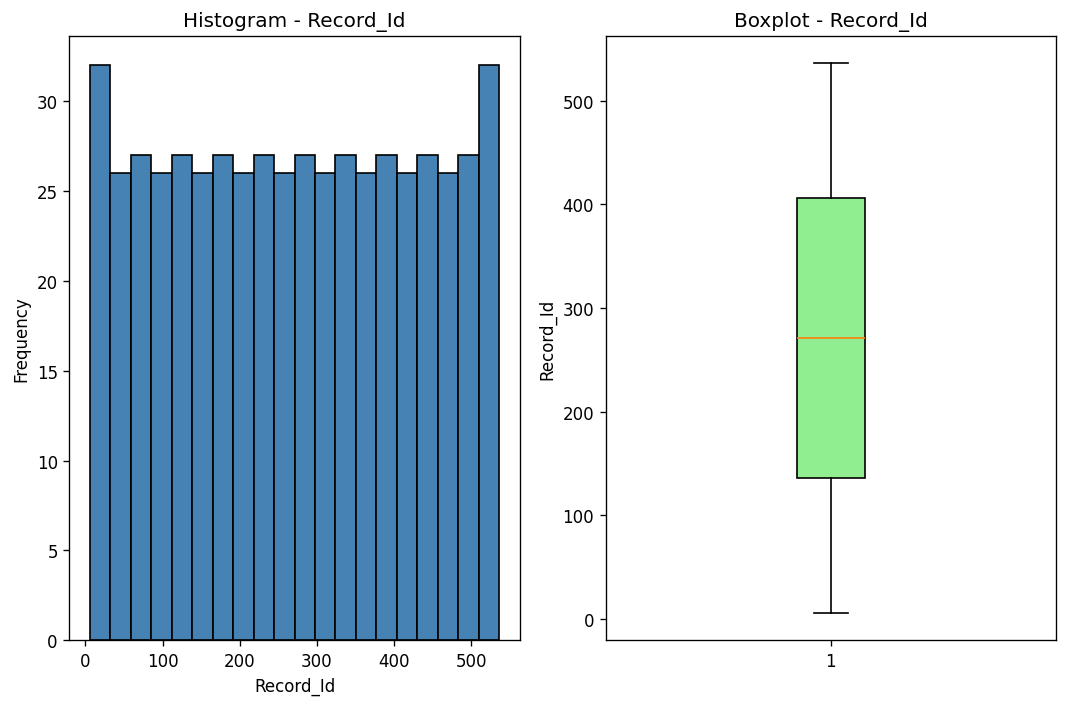

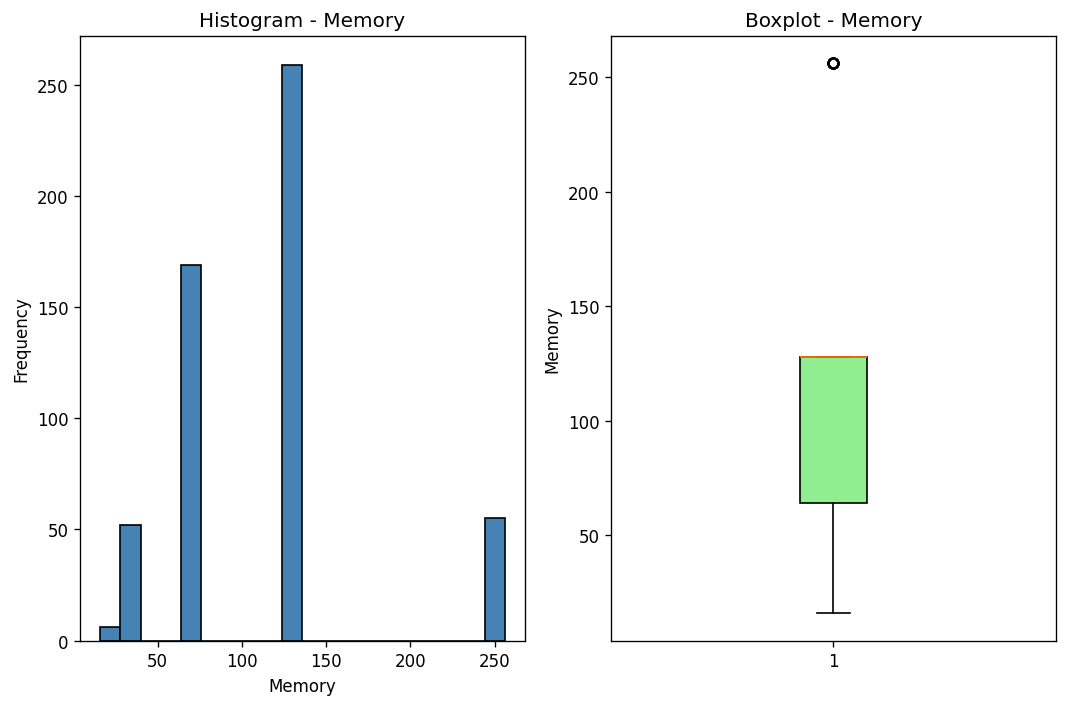

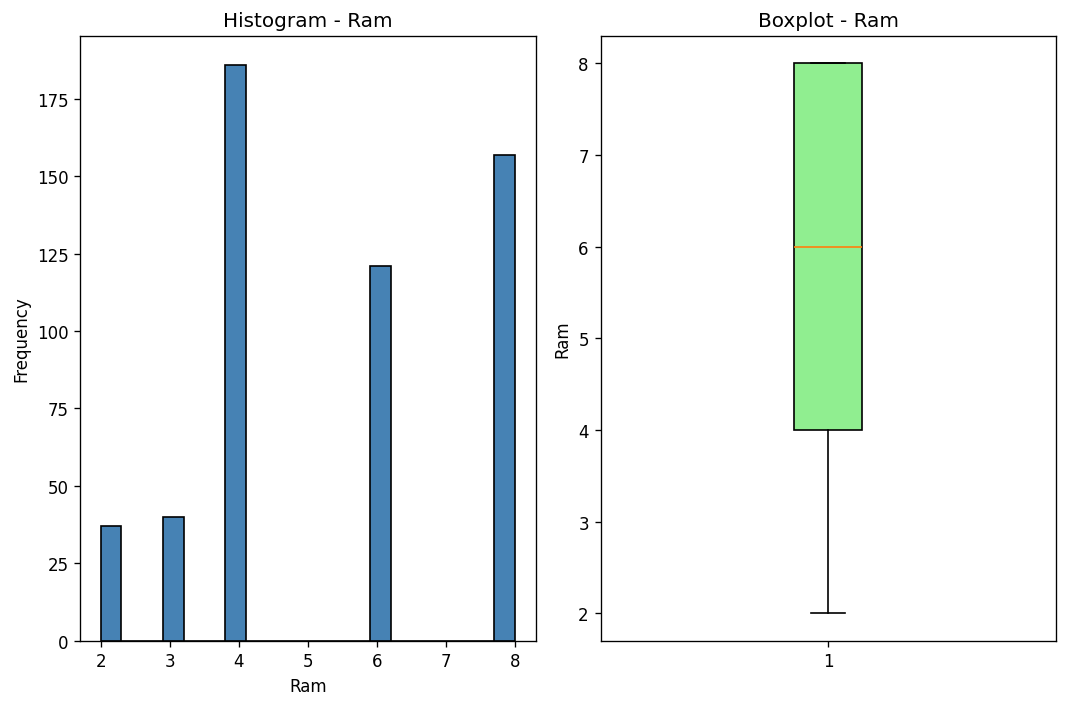

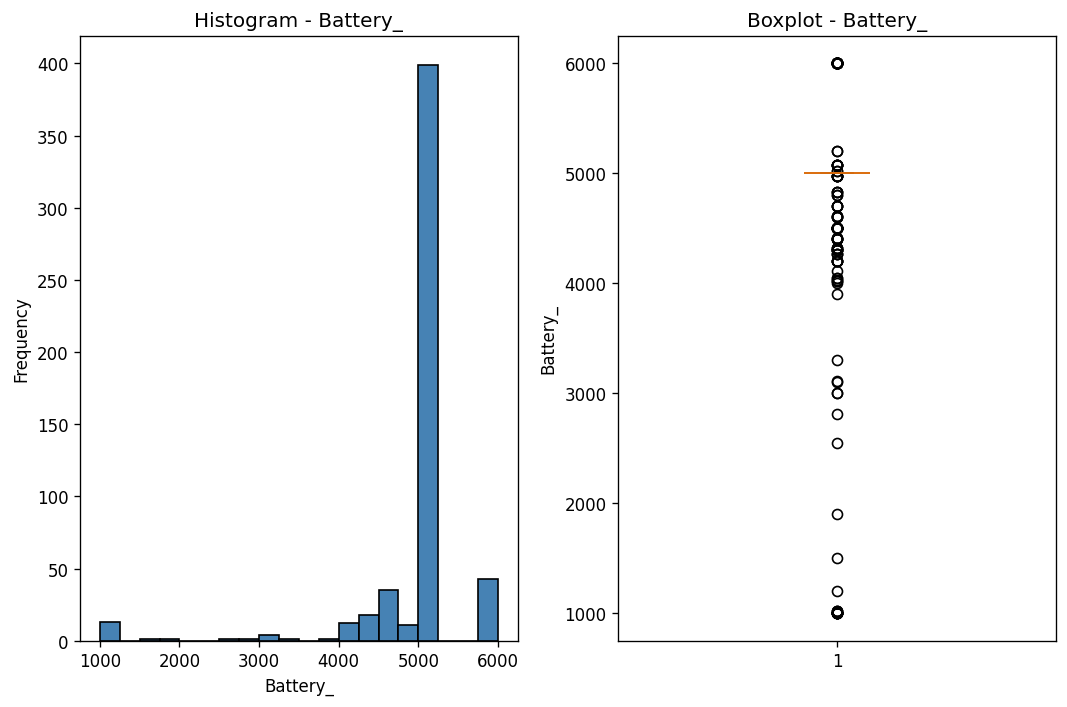

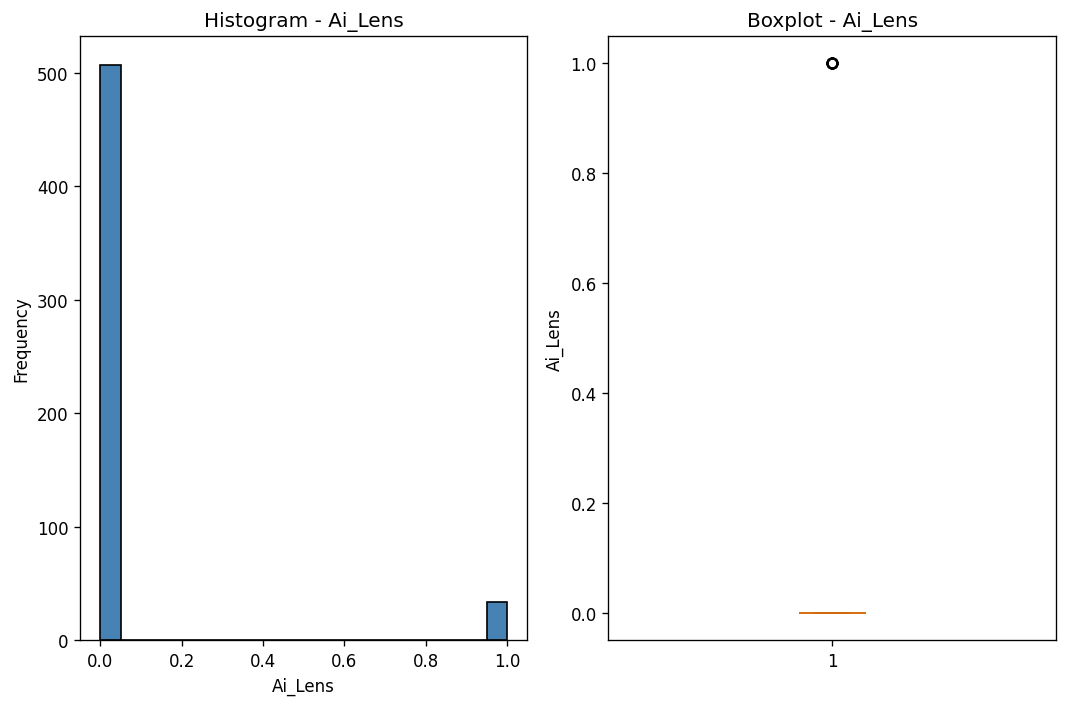

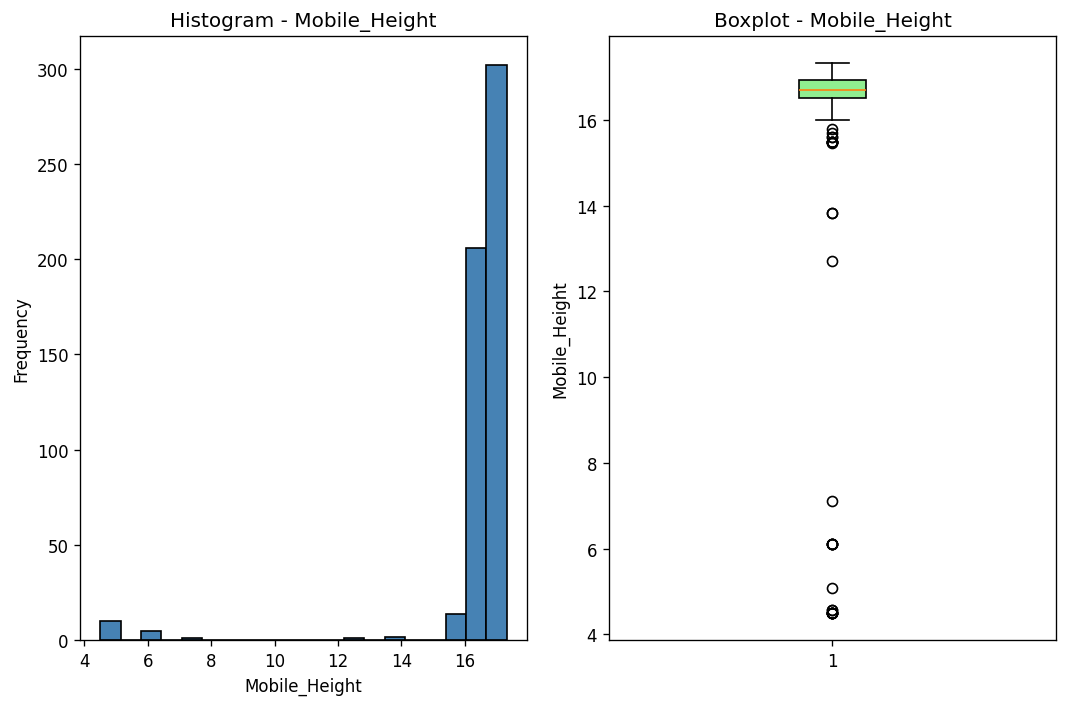

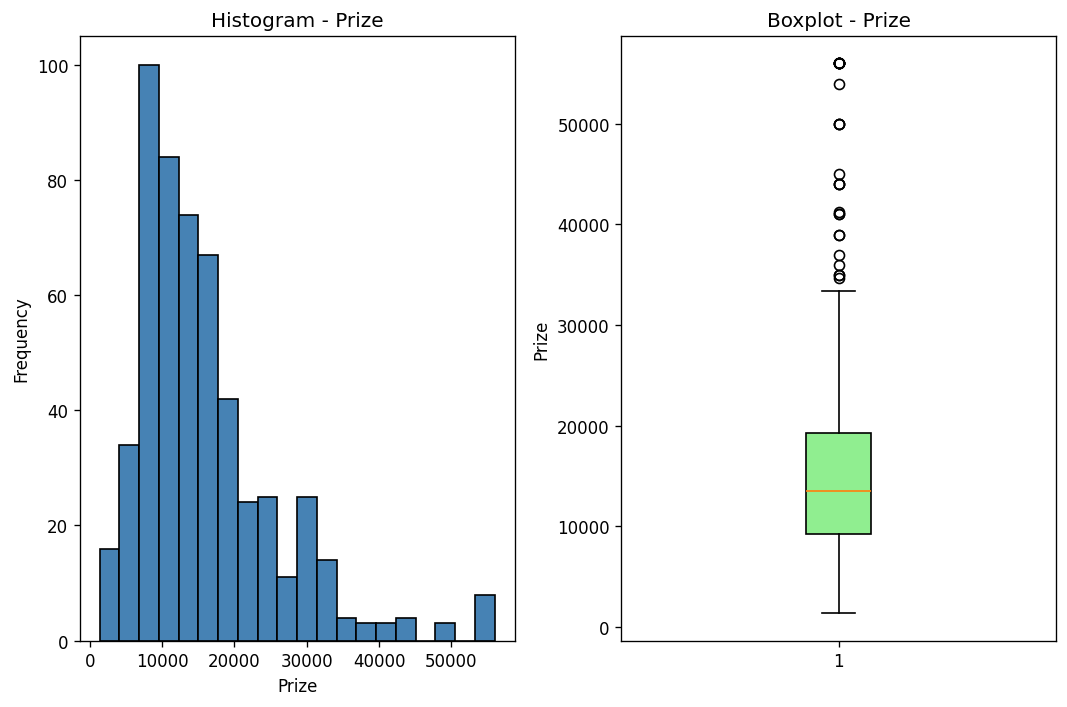

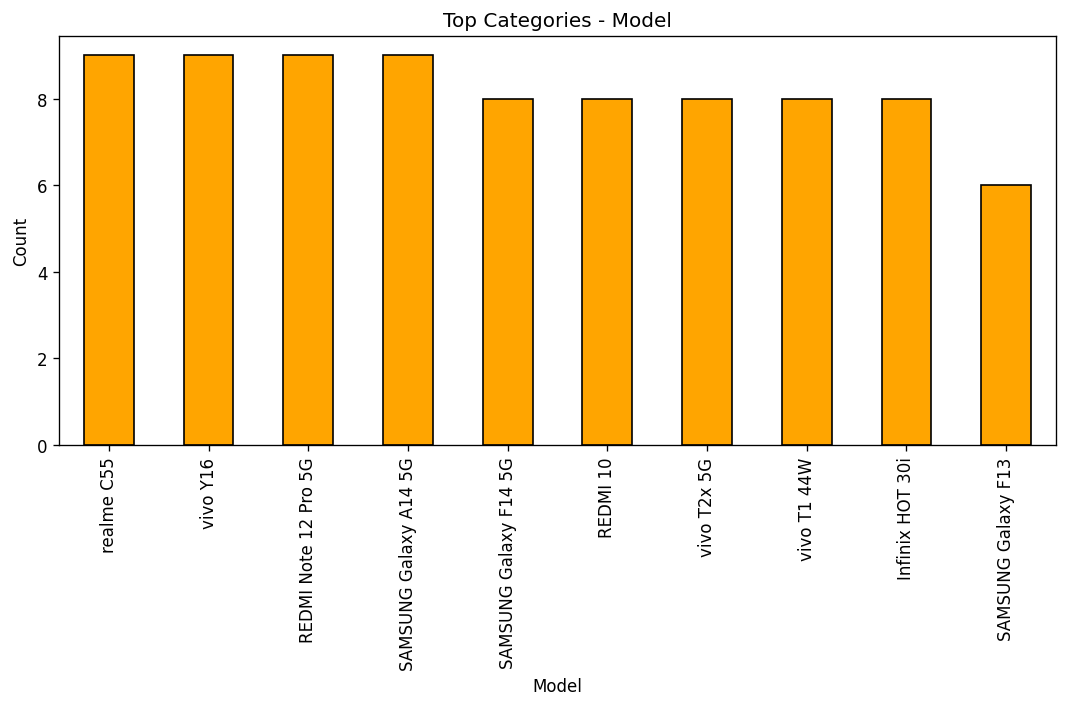

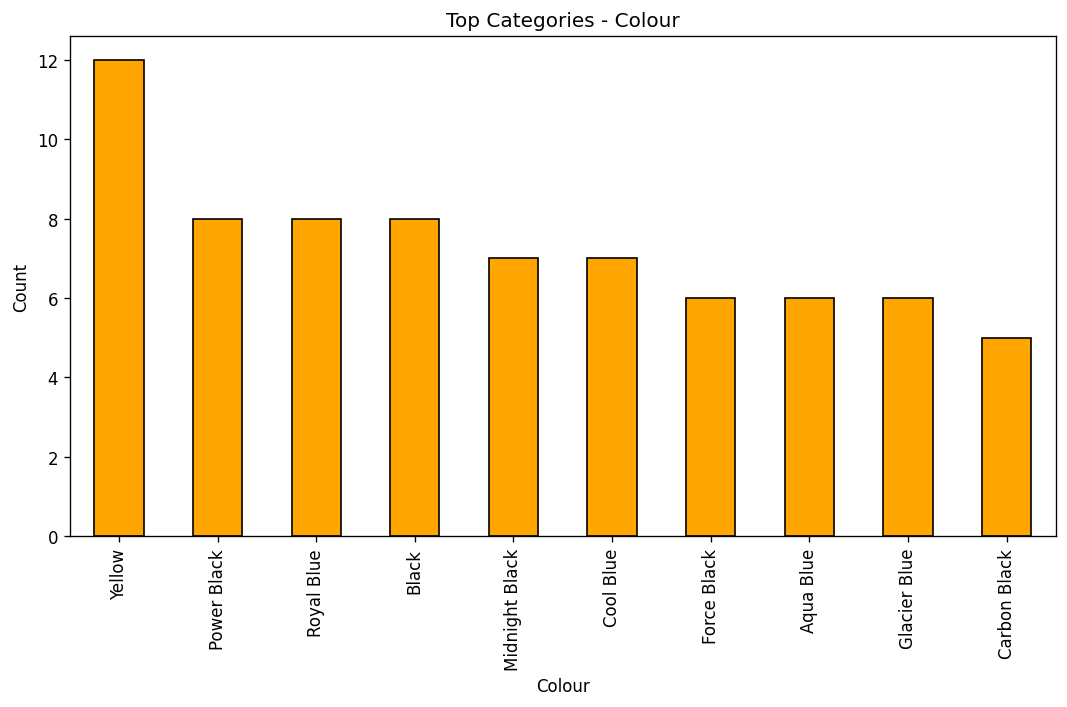

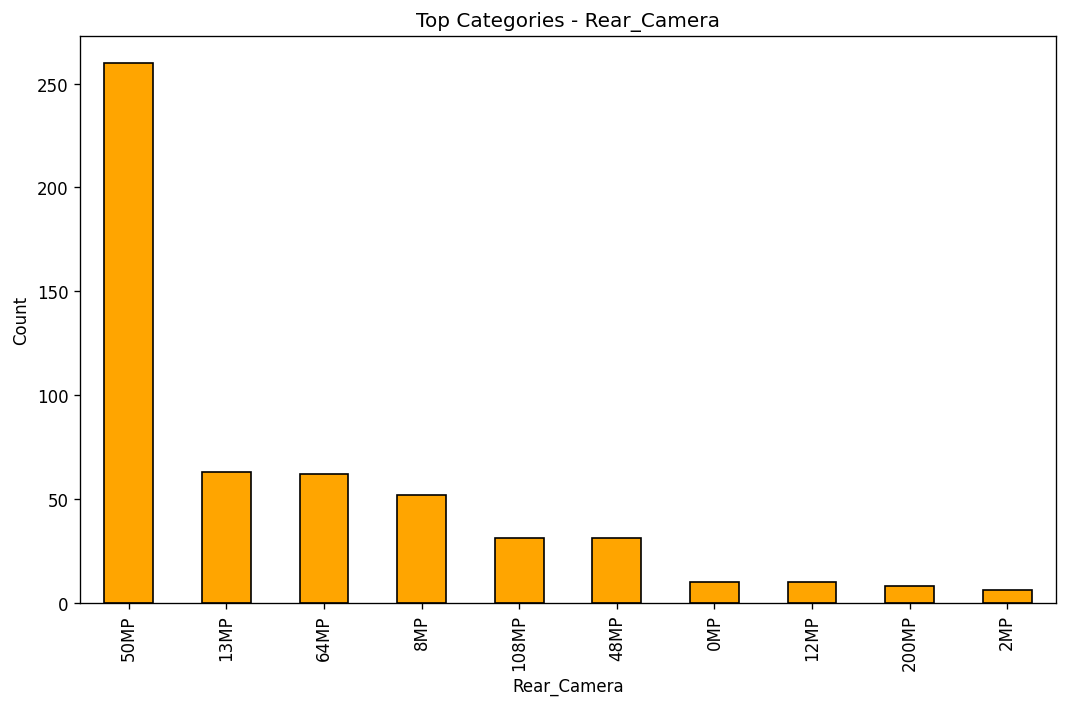

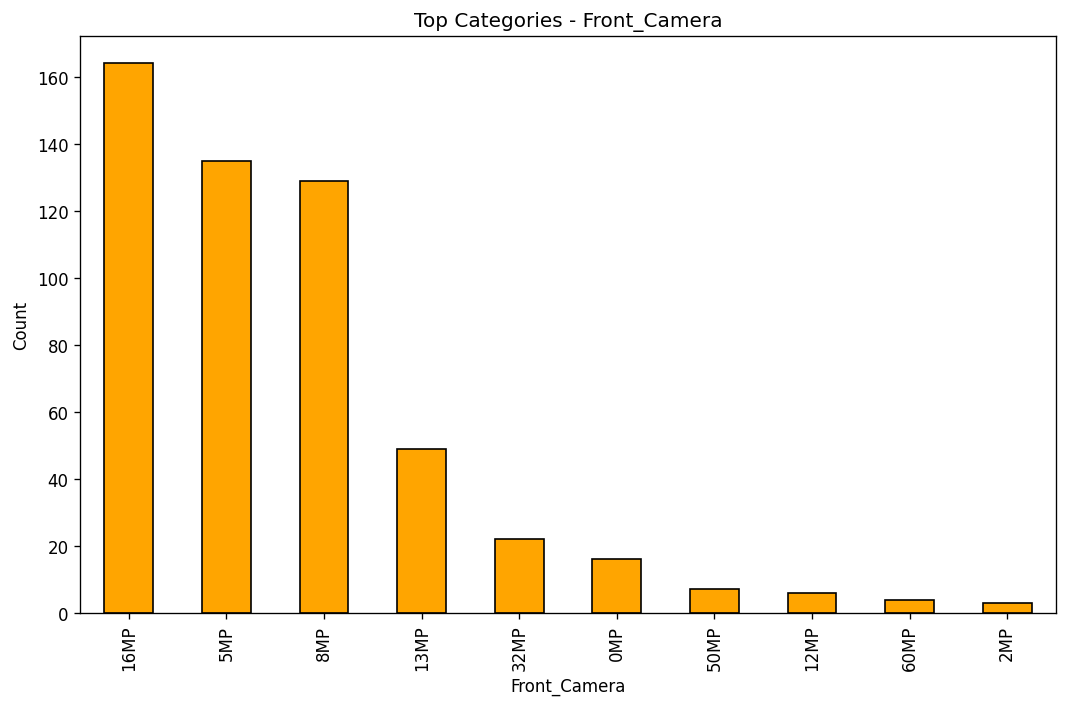

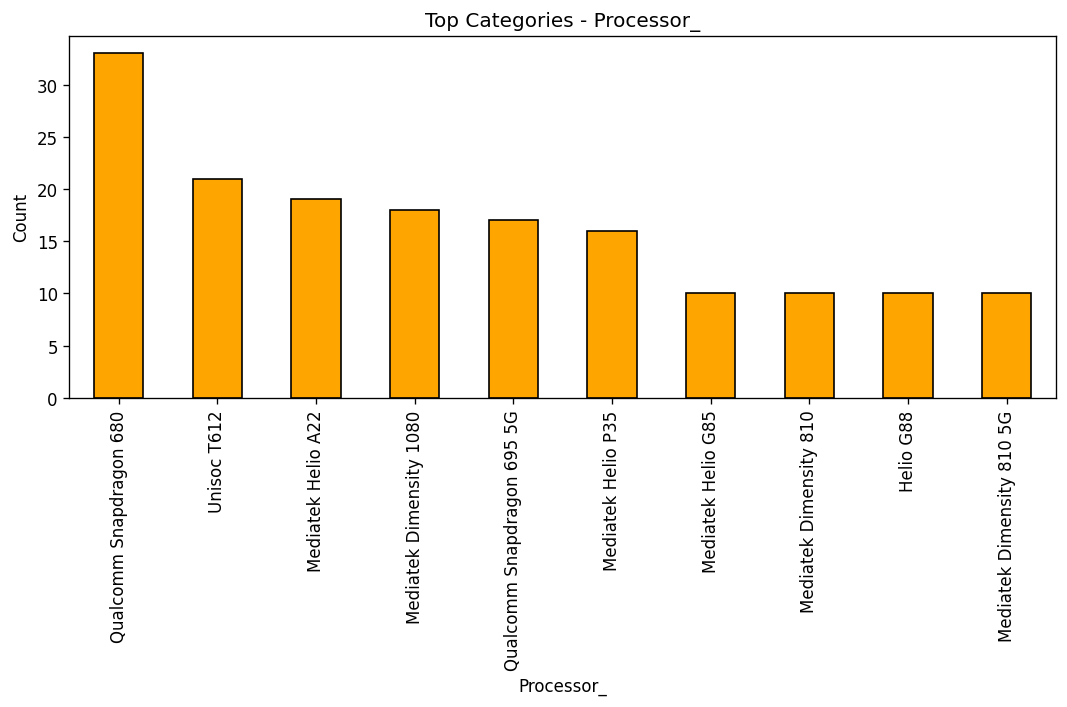

2025-11-16 00:08:02,574 - INFO - Removed existing sheet: Univariate Analysis
2025-11-16 00:08:04,141 - INFO - Univariate Analysis saved successfully with tables and visible graphs.


Univariate plots saved to folder: .\univariate_images


In [41]:
# ==========================================
# Univariate Analysis (with image saving)
# ==========================================
logger.info("Performing Univariate Analysis...")

# === Directory to save univariate images ===
uni_var_dir = os.path.join(os.path.dirname(DATA_PATH), "univariate_images")
os.makedirs(uni_var_dir, exist_ok=True)

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# -------------------------------
# Numeric Summary
# -------------------------------
if numeric_cols:
    numerical_summary = pd.DataFrame({
        "Feature": numeric_cols,
        "Mean": df[numeric_cols].mean().round(2),
        "Median": df[numeric_cols].median().round(2),
        "Std Dev": df[numeric_cols].std().round(2),
        "Skewness": df[numeric_cols].skew().round(2),
        "Kurtosis": df[numeric_cols].kurt().round(2)
    }).reset_index(drop=True)
else:
    numerical_summary = pd.DataFrame(columns=["Feature", "Mean", "Median", "Std Dev", "Skewness", "Kurtosis"])

# -------------------------------
# Categorical Summary
# -------------------------------
if categorical_cols:
    categorical_summary = pd.DataFrame({
        "Feature": categorical_cols,
        "Unique Count": [df[col].nunique() for col in categorical_cols],
        "Most Frequent": [df[col].mode()[0] if not df[col].mode().empty else None for col in categorical_cols],
        "Top Frequency": [df[col].value_counts().iloc[0] if not df[col].value_counts().empty else 0 for col in categorical_cols]
    }).reset_index(drop=True)
else:
    categorical_summary = pd.DataFrame(columns=["Feature", "Unique Count", "Most Frequent", "Top Frequency"])

display(numerical_summary)
display(categorical_summary)

# -------------------------------
# Create and Save Graphs
# -------------------------------
saved_plot_paths = []

# Numeric features plots
for col in numeric_cols:
    plt.figure(figsize=(9, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df[col].dropna(), bins=20, color='steelblue', edgecolor='black')
    plt.title(f"Histogram - {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.boxplot(df[col].dropna(), vert=True, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    plt.title(f"Boxplot - {col}")
    plt.ylabel(col)
    plt.tight_layout()

    # === Save image to univariate_images folder ===
    img_path = os.path.join(uni_var_dir, f"{col}_univariate.png")
    plt.savefig(img_path, dpi=180, bbox_inches='tight')
    saved_plot_paths.append(img_path)

    # Also save to buffer for Excel embedding
    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=180, bbox_inches='tight')
    buf.seek(0)
    saved_plot_paths.append(buf)

    plt.show()
    plt.close()

# Categorical features plots
for col in categorical_cols:
    plt.figure(figsize=(9, 6))
    df[col].value_counts().head(10).plot(kind='bar', color='orange', edgecolor='black')
    plt.title(f"Top Categories - {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()

    # === Save image to univariate_images folder ===
    img_path = os.path.join(uni_var_dir, f"{col}_univariate.png")
    plt.savefig(img_path, dpi=180, bbox_inches='tight')
    saved_plot_paths.append(img_path)

    # Also save to buffer for Excel embedding
    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=180, bbox_inches='tight')
    buf.seek(0)
    saved_plot_paths.append(buf)

    plt.show()
    plt.close()

# -------------------------------
# Write to Excel
# -------------------------------
sheet_name = "Univariate Analysis"
wb = load_workbook(DATA_PATH)

if sheet_name in wb.sheetnames:
    del wb[sheet_name]
    logger.info(f"Removed existing sheet: {sheet_name}")

ws_uni = wb.create_sheet(sheet_name)

# Title
header_text = "Univariate Analysis Overview"
ws_uni.merge_cells("A1:F2")
top_cell = ws_uni["A1"]
top_cell.value = header_text
top_cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')
top_cell.font = Font(color='FFFFFF', bold=True, size=13)
top_cell.alignment = Alignment(horizontal='center', vertical='center')

# Styling
thin = Side(border_style="thin", color="000000")
border_style = Border(left=thin, right=thin, top=thin, bottom=thin)
align_center = Alignment(horizontal='center', vertical='center')

# Write first table (numerical_summary)
start_row = 4
for col_idx, col_name in enumerate(numerical_summary.columns, start=1):
    cell = ws_uni.cell(row=start_row, column=col_idx)
    cell.value = col_name
    cell.fill = PatternFill(start_color='003366', end_color='003366', fill_type='solid')
    cell.font = Font(color='FFFFFF', bold=True)
    cell.alignment = align_center
    cell.border = border_style

for r_idx, row in enumerate(numerical_summary.itertuples(index=False), start=start_row + 1):
    for c_idx, value in enumerate(row, start=1):
        cell = ws_uni.cell(row=r_idx, column=c_idx)
        cell.value = value
        cell.alignment = align_center
        cell.border = border_style

# Adjust column width
for col_idx in range(1, numerical_summary.shape[1] + 1):
    col_letter = get_column_letter(col_idx)
    max_length = max(len(str(cell.value)) for cell in ws_uni[col_letter] if cell.value)
    ws_uni.column_dimensions[col_letter].width = max_length + 2

# Insert numeric graphs
row_position = start_row + len(numerical_summary) + 2
for plot_buf in saved_plot_paths[:len(numeric_cols)]:
    if isinstance(plot_buf, BytesIO):
        img = XLImage(plot_buf)
        img.width = 700
        img.height = 350
        ws_uni.add_image(img, f"A{row_position}")
        row_position += 22

# Write second table (categorical_summary)
row_position += 2
for col_idx, col_name in enumerate(categorical_summary.columns, start=1):
    cell = ws_uni.cell(row=row_position, column=col_idx)
    cell.value = col_name
    cell.fill = PatternFill(start_color='006600', end_color='006600', fill_type='solid')
    cell.font = Font(color='FFFFFF', bold=True)
    cell.alignment = align_center
    cell.border = border_style

for r_idx, row in enumerate(categorical_summary.itertuples(index=False), start=row_position + 1):
    for c_idx, value in enumerate(row, start=1):
        cell = ws_uni.cell(row=r_idx, column=c_idx)
        cell.value = value
        cell.alignment = align_center
        cell.border = border_style

# Insert categorical graphs
row_position = row_position + len(categorical_summary) + 2
for plot_buf in saved_plot_paths[len(numeric_cols):]:
    if isinstance(plot_buf, BytesIO):
        img = XLImage(plot_buf)
        img.width = 700
        img.height = 350
        ws_uni.add_image(img, f"A{row_position}")
        row_position += 22

# Save workbook safely
with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
    temp_filename = tmp.name
    wb.save(temp_filename)
wb.close()
time.sleep(0.5)
shutil.move(temp_filename, DATA_PATH)

logger.info(f"{sheet_name} saved successfully with tables and visible graphs.")
print(f"Univariate plots saved to folder: {uni_var_dir}")

### Bivariate Analysis
Examines the relationship between two variables to identify patterns, trends, and potential dependencies. Common techniques include scatterplots, boxplots, and grouped bar charts.
We will use the variable pairs to do the bivariate analysis.

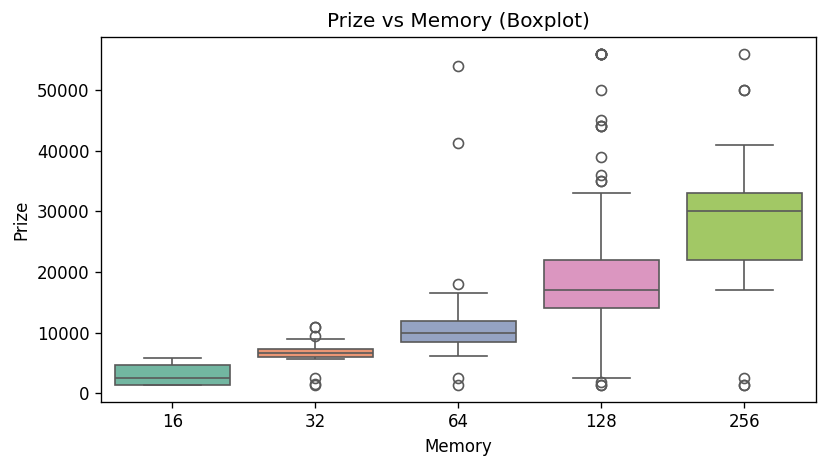

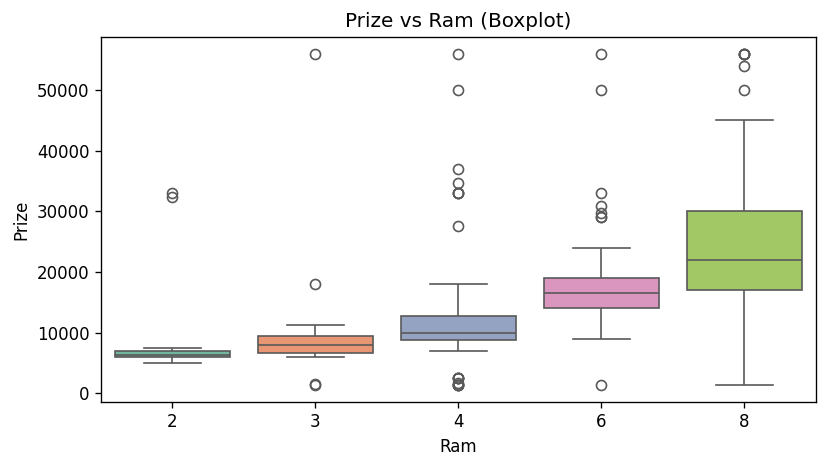

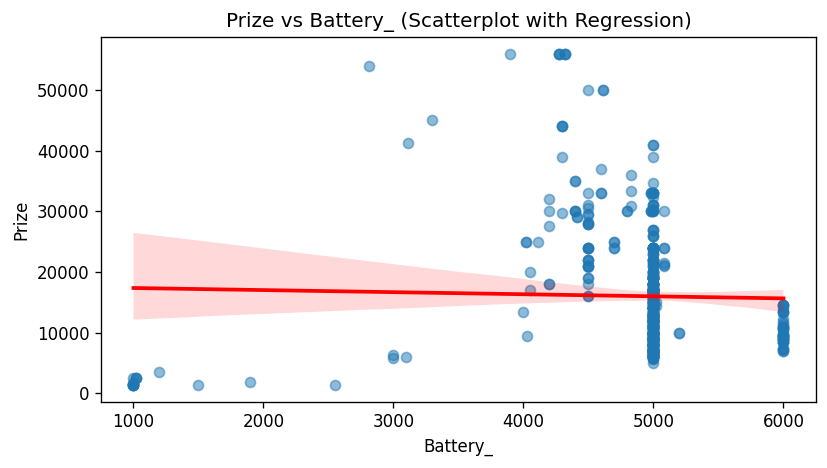

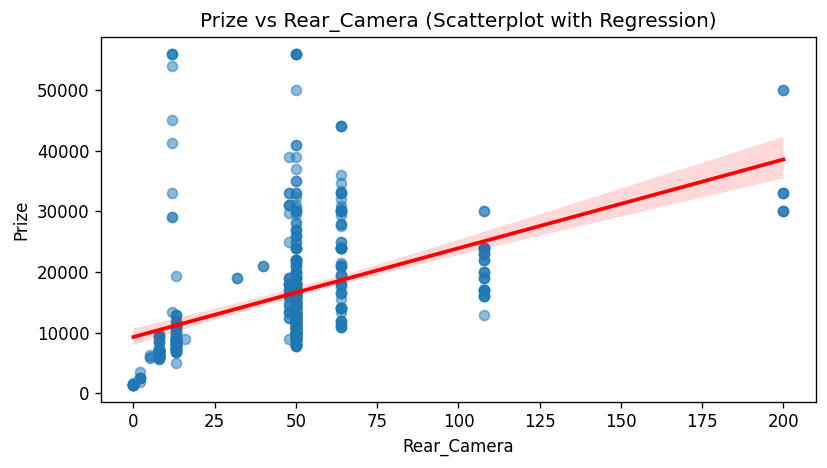

In [42]:
# === Directory to save bivariate images ===
bi_var_dir = os.path.join(os.path.dirname(DATA_PATH), "bivariate_images")
os.makedirs(bi_var_dir, exist_ok=True)

# === Feature pairs for bivariate analysis ===
pairs = [
    ('Prize', 'Memory'),
    ('Prize', 'Ram'),
    ('Prize', 'Battery_'),
    ('Prize', 'Rear_Camera')
]

# === Clean numeric features (remove units like 'MP', 'mAh') ===
numeric_features = ['Memory', 'Ram', 'Battery_', 'Rear_Camera']
for col in numeric_features:
    df[col] = df[col].astype(str).str.extract(r'(\d+\.?\d*)')[0]  # extract numeric part
    df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to float

# === Load workbook and preserve all sheets ===
wb = load_workbook(DATA_PATH)

# Remove only 'Bivariate Analysis' if it exists
sheet_name = "Bivariate Analysis"
if sheet_name in wb.sheetnames:
    ws_old = wb[sheet_name]
    wb.remove(ws_old)

# Create new sheet
ws = wb.create_sheet(sheet_name)

# === Insert header ===
ws['B2'] = 'Bivariate Analysis Overview'
ws.merge_cells('B2:I3')
ws['B2'].font = Font(bold=True, color='FFFFFF')
ws['B2'].fill = PatternFill(start_color='4BACC6', end_color='4BACC6', fill_type='solid')
ws['B2'].alignment = Alignment(horizontal='center', vertical='center')

# === Step 1: Create correlation table above plots ===
start_row = 5
ws.cell(row=start_row, column=2, value="Feature")
ws.cell(row=start_row, column=3, value="Correlation with Prize")

# Styling for table header
thin = Side(border_style="thin", color="000000")
for col in [2, 3]:
    cell = ws.cell(row=start_row, column=col)
    cell.font = Font(bold=True, color='FFFFFF')
    cell.fill = PatternFill(start_color='003366', end_color='003366', fill_type='solid')
    cell.alignment = Alignment(horizontal='center', vertical='center')
    cell.border = Border(left=thin, right=thin, top=thin, bottom=thin)

# Fill correlation values
for idx, (_, feature) in enumerate(pairs, start=1):
    ws.cell(row=start_row+idx, column=2, value=feature)
    corr_value = df['Prize'].corr(df[feature]).round(2)
    ws.cell(row=start_row+idx, column=3, value=corr_value)
    for col in [2, 3]:
        cell = ws.cell(row=start_row+idx, column=col)
        cell.alignment = Alignment(horizontal='center', vertical='center')
        cell.border = Border(left=thin, right=thin, top=thin, bottom=thin)

# === Step 2: Generate and save plots ===
image_paths = []
for x, y in pairs:
    plt.figure(figsize=(7, 4))
    if df[y].dtype == 'object' or len(df[y].unique()) < 10:
        # Categorical -> boxplot (fixed deprecation warning)
        sns.boxplot(x=df[y], y=df[x], hue=df[y], palette='Set2', dodge=False, legend=False)
        plt.title(f'{x} vs {y} (Boxplot)')
    else:
        # Numeric -> scatterplot with regression
        sns.regplot(x=df[y], y=df[x], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
        plt.title(f'{x} vs {y} (Scatterplot with Regression)')
    plt.xlabel(y)
    plt.ylabel(x)
    plt.tight_layout()
    
    # Save image
    img_path = os.path.join(bi_var_dir, f'{x}_vs_{y}.png')
    plt.savefig(img_path, dpi=120)
    plt.show()
    plt.close()
    image_paths.append(img_path)

# === Step 3: Embed plots into Excel below table ===
plot_start_row = start_row + len(pairs) + 3
for img_path in image_paths:
    img = XLImage(img_path)
    img.width *= 0.6
    img.height *= 0.6
    ws.add_image(img, f'B{plot_start_row}')
    plot_start_row += int(img.height / 20) + 3  # Add spacing

# === Step 4: Save workbook ===
wb.save(DATA_PATH)

### Multivariate Analysis

We use:
- Pair plots to visualize interactions among multiple numerical features.
- Heatmaps to detect strong correlations.


Correlation Matrix (Numeric Features Only):
               Record_Id  Memory   Ram  Battery_  Rear_Camera  Front_Camera  \
Record_Id           1.00    0.12  0.09     -0.07         0.04          0.24   
Memory              0.12    1.00  0.63     -0.05         0.53          0.50   
Ram                 0.09    0.63  1.00     -0.11         0.44          0.49   
Battery_           -0.07   -0.05 -0.11      1.00         0.20          0.03   
Rear_Camera         0.04    0.53  0.44      0.20         1.00          0.51   
Front_Camera        0.24    0.50  0.49      0.03         0.51          1.00   
Ai_Lens            -0.17   -0.09 -0.08      0.15        -0.04         -0.11   
Mobile_Height       0.07    0.07  0.06      0.87         0.30          0.24   
Prize               0.34    0.61  0.58     -0.03         0.46          0.58   

               Ai_Lens  Mobile_Height  Prize  
Record_Id        -0.17           0.07   0.34  
Memory           -0.09           0.07   0.61  
Ram              -0.08  

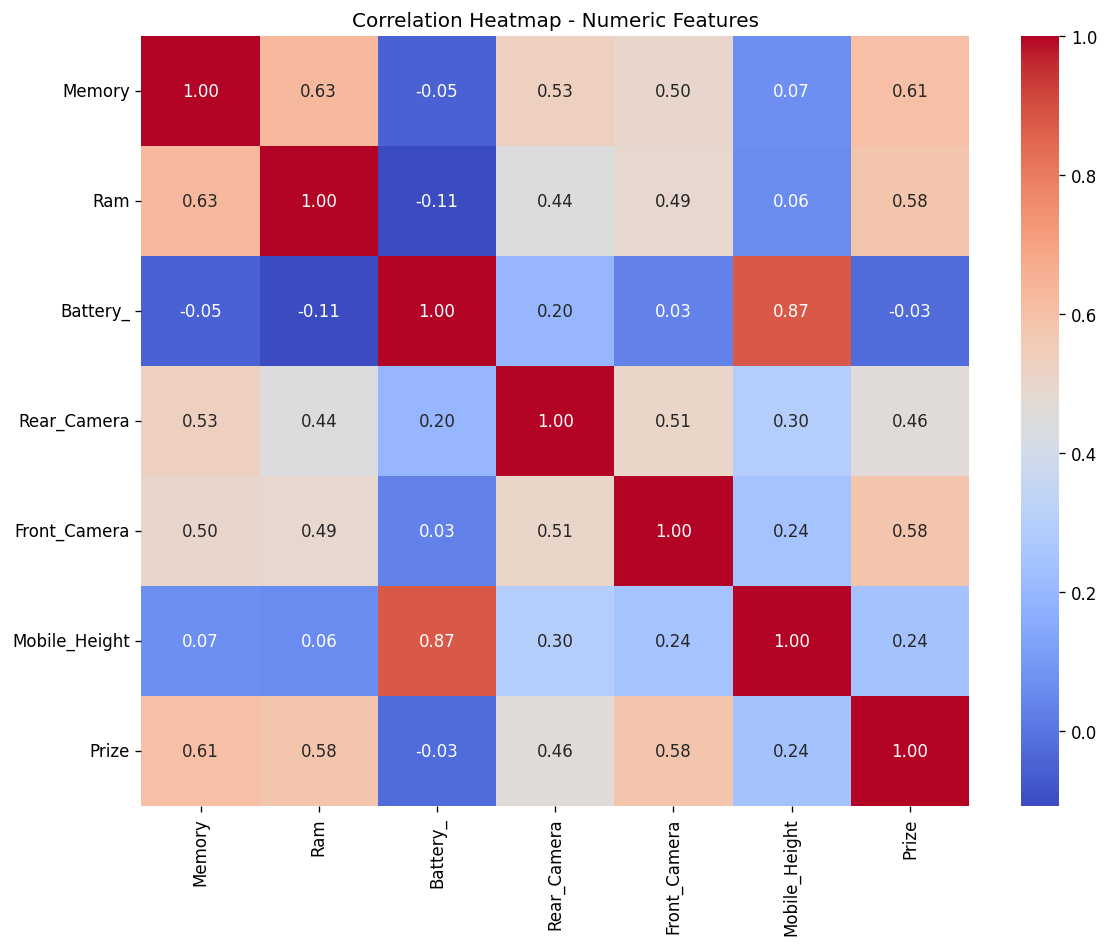

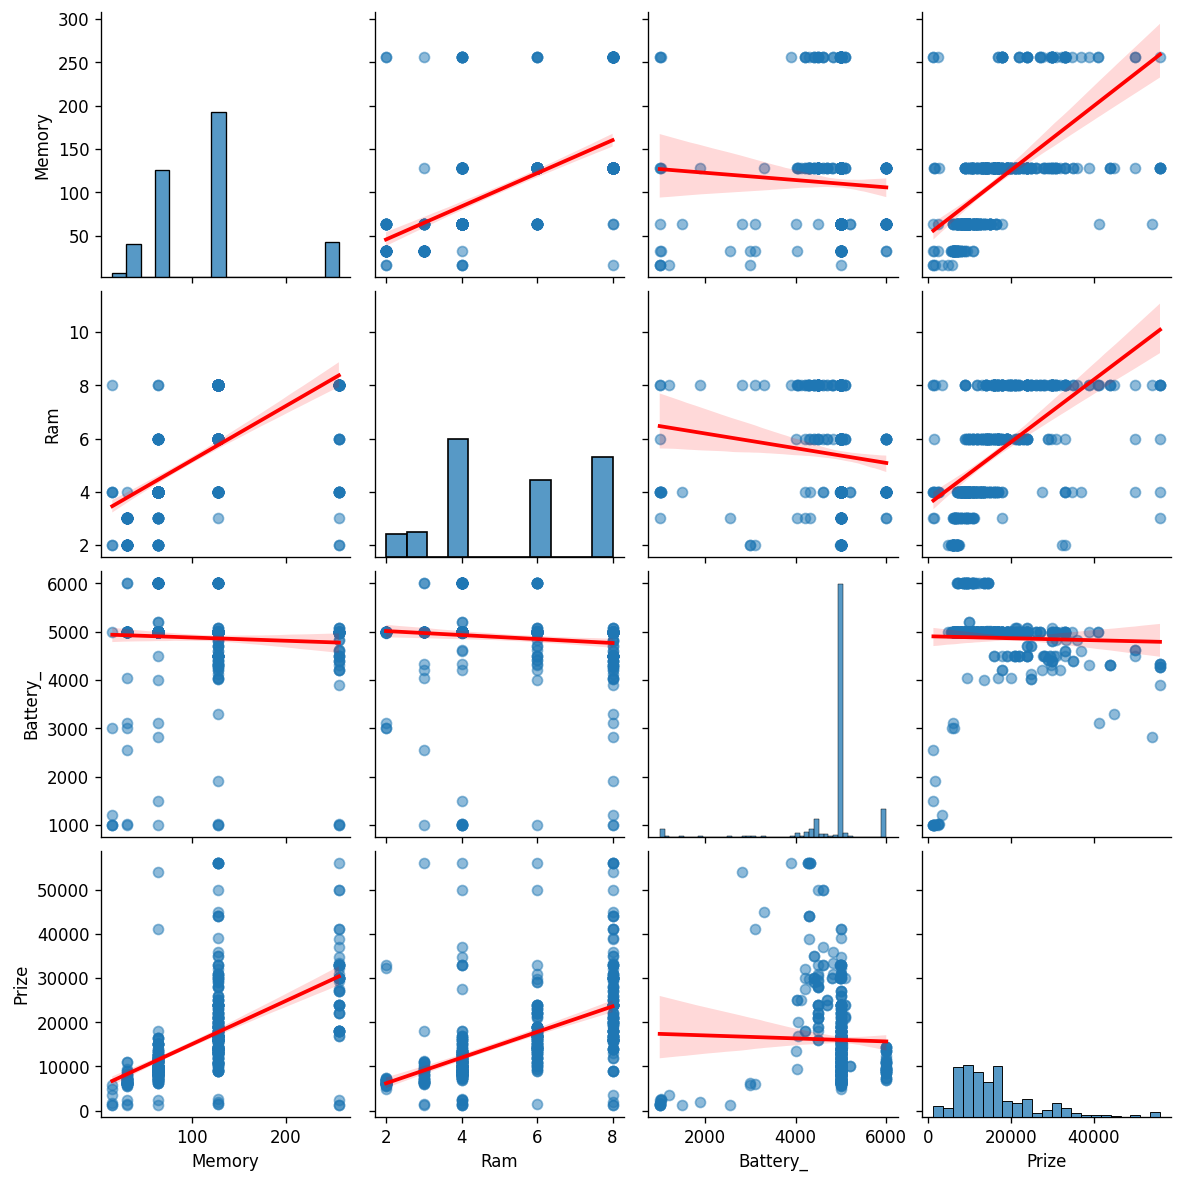

In [43]:
# === Directory to save multivariate images ===
multi_var_dir = os.path.join(os.path.dirname(DATA_PATH), "multivariate_images")
os.makedirs(multi_var_dir, exist_ok=True)

# === Identify numeric and categorical features ===
numeric_features = ['Memory', 'Ram', 'Battery_', 'Rear_Camera', 'Front_Camera', 'Mobile_Height', 'Prize']
categorical_features = ['Model', 'Colour', 'Processor_', 'Ai_Lens']

# === Clean numeric features ===
for col in numeric_features:
    df[col] = df[col].astype(str).str.extract(r'(\d+\.?\d*)')[0]
    df[col] = pd.to_numeric(df[col], errors='coerce')

# === Load workbook and preserve all sheets ===
wb = load_workbook(DATA_PATH)

# Remove existing 'Multivariate Analysis' sheet if exists
sheet_name = "Multivariate Analysis"
if sheet_name in wb.sheetnames:
    ws_old = wb[sheet_name]
    wb.remove(ws_old)

# Create new sheet
ws = wb.create_sheet(sheet_name)

# === Insert header ===
ws['B2'] = 'Multivariate Analysis Overview'
ws.merge_cells('B2:M3')
ws['B2'].font = Font(bold=True, color='FFFFFF')
ws['B2'].fill = PatternFill(start_color='4BACC6', end_color='4BACC6', fill_type='solid')
ws['B2'].alignment = Alignment(horizontal='center', vertical='center')

# === Step 1: Select only numeric columns for correlation ===
numeric_df = df.select_dtypes(include=['int64', 'float64'])

print("Correlation Matrix (Numeric Features Only):")
print(numeric_df.corr().round(2))

# === Step 1: Correlation Heatmap ===
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap - Numeric Features")
plt.tight_layout()

heatmap_path = os.path.join(multi_var_dir, 'correlation_heatmap.png')
plt.savefig(heatmap_path, dpi=120)
plt.show()
plt.close()

# === Step 2: Pairplot for numeric features ===
pairplot_features = ['Memory', 'Ram', 'Battery_', 'Prize']
sns.pairplot(df[pairplot_features], kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'alpha':0.5}})
pairplot_path = os.path.join(multi_var_dir, 'pairplot.png')
plt.savefig(pairplot_path, dpi=120)
plt.show()
plt.close()

# === Step 3: Boxplots for categorical vs Prize (optional) ===
# categorical_boxplots = ['Processor_']  # choose 1-2 key categorical features
# boxplot_paths = []
# for cat in categorical_boxplots:
#     plt.figure(figsize=(8, 4))
#     sns.boxplot(x=df[cat], y=df['Prize'], hue=df[cat], dodge=False, palette='Set2', legend=False)
#     plt.title(f'Prize by {cat}')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     path = os.path.join(multi_var_dir, f'Prize_vs_{cat}.png')
#     plt.savefig(path, dpi=120)
#     plt.show()
#     plt.close()
#     boxplot_paths.append(path)

# === Step 4: Embed plots into Excel ===
# all_images = [heatmap_path, pairplot_path] + boxplot_paths
all_images = [heatmap_path, pairplot_path]
start_row = 5
for img_path in all_images:
    img = XLImage(img_path)
    img.width *= 0.6
    img.height *= 0.6
    ws.add_image(img, f'B{start_row}')
    start_row += int(img.height / 20) + 3

# === Step 5: Save workbook ===
wb.save(DATA_PATH)

### Feature Engineering
Introduces new variables that might enhance the model's ability to predict house prices. For instance, calculate the price per square foot or engineer a feature representing the property's age.

2025-11-16 00:08:15,881 - INFO - Loaded cleaned data shape: (541, 12)
2025-11-16 00:08:15,900 - INFO - Engineered columns prepared


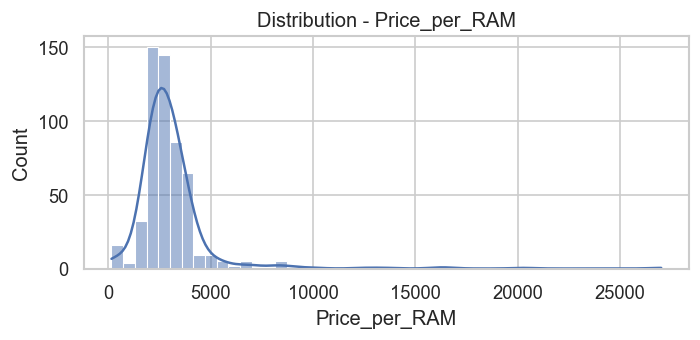

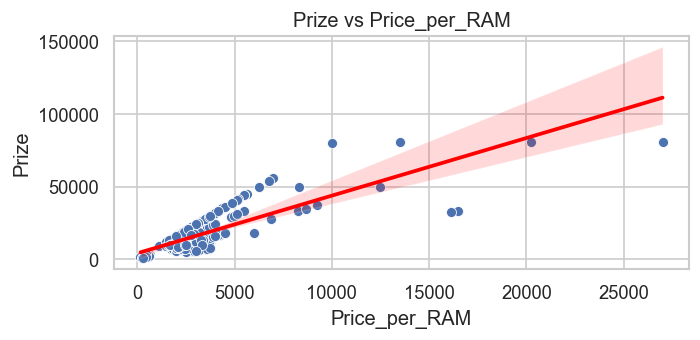

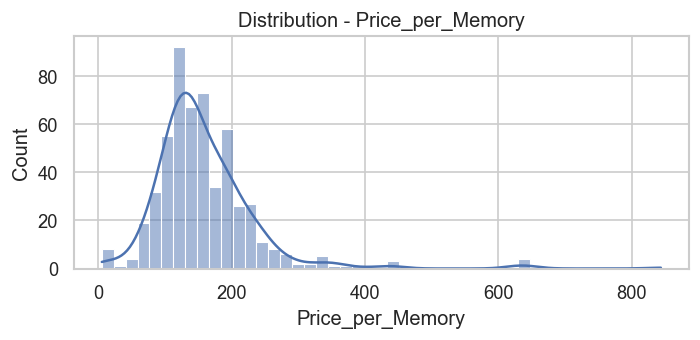

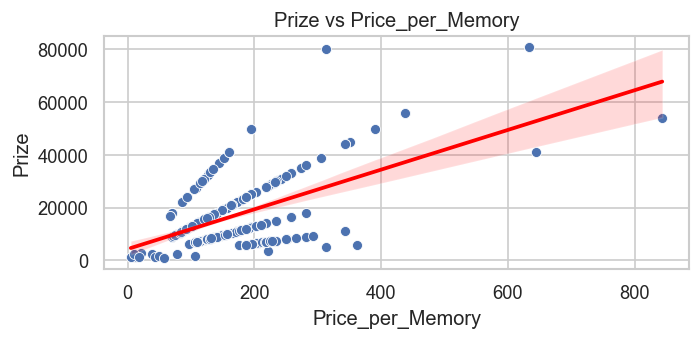

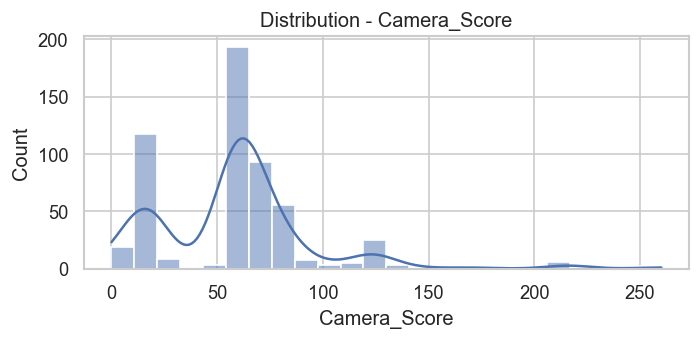

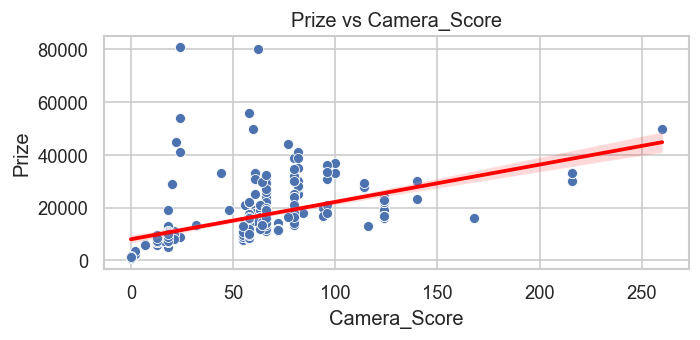

2025-11-16 00:08:19,727 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-16 00:08:19,735 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


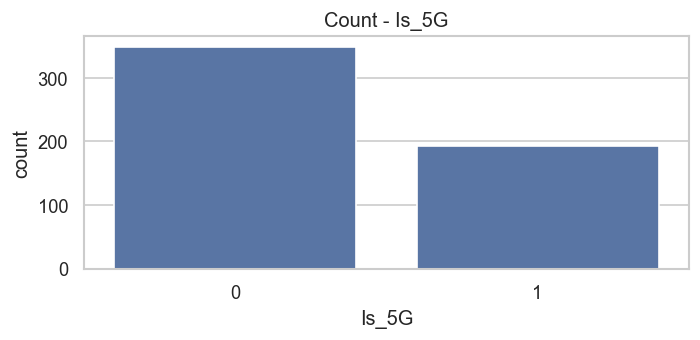

2025-11-16 00:08:22,055 - INFO - Done — Sheets added and images saved.
2025-11-16 00:08:22,057 - INFO - Permanent feature-engineered images saved to: ./feature_engineered_images


In [44]:
# -------------------------
# Configuration / logging
# -------------------------
INPUT_SHEET = "Cleaned Processed Flip Data"
ENGINEERED_SHEET = "Engineered Features"
REPORT_SHEET = "Feature Report"

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# -------------------------
# Create permanent image folder
# -------------------------
permanent_img_dir = "./feature_engineered_images"
os.makedirs(permanent_img_dir, exist_ok=True)

# -------------------------
# Load cleaned data
# -------------------------
df_clean = pd.read_excel(DATA_PATH, sheet_name=INPUT_SHEET)
logger.info("Loaded cleaned data shape: %s", df_clean.shape)

df = df_clean.copy()
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_")

# -------------------------
# Helper
# -------------------------
def extract_first_number(x):
    try:
        m = re.search(r"(\d+\.?\d*)", str(x))
        return float(m.group(1)) if m else np.nan
    except:
        return np.nan

# -------------------------
# Engineered features
# -------------------------
if "Prize" not in df.columns:
    alt = [c for c in df.columns if c.lower() in ("prize", "price", "cost")]
    df["Prize"] = pd.to_numeric(df[alt[0]], errors="coerce") if alt else np.nan
else:
    df["Prize"] = pd.to_numeric(df["Prize"], errors="coerce")

df["Ram_num"] = pd.to_numeric(
    df["Ram"].astype(str).str.extract(r"(\d+\.?\d*)")[0], errors="coerce"
) if "Ram" in df.columns else np.nan

df["Memory_num"] = pd.to_numeric(
    df["Memory"].astype(str).str.extract(r"(\d+\.?\d*)")[0], errors="coerce"
) if "Memory" in df.columns else np.nan

df["Rear_Camera_num"] = df["Rear_Camera"].apply(extract_first_number) if "Rear_Camera" in df.columns else np.nan
df["Front_Camera_num"] = df["Front_Camera"].apply(extract_first_number) if "Front_Camera" in df.columns else np.nan

df["Price_per_RAM"] = df["Prize"] / df["Ram_num"].replace({0: np.nan})
df["Price_per_Memory"] = df["Prize"] / df["Memory_num"].replace({0: np.nan})
df["Camera_Score"] = df["Rear_Camera_num"].fillna(0) + df["Front_Camera_num"].fillna(0)
df["Is_5G"] = df["Model"].astype(str).str.contains(r"\b5G\b", case=False, na=False).astype(int)

engineered_cols = ["Price_per_RAM", "Price_per_Memory", "Camera_Score", "Is_5G"]

df_engineered = df[engineered_cols].copy()
if "Record_Id" in df.columns:
    df_engineered.insert(0, "Record_Id", df["Record_Id"])

logger.info("Engineered columns prepared")

# -------------------------
# Notebook plots + saving to Excel + saving to folder
# -------------------------
sns.set(style="whitegrid")
plot_paths = []
# -------------------------
# Create permanent image folder
# -------------------------
feat_img_dir = "./feat_images"
os.makedirs(feat_img_dir, exist_ok=True)

def save_plot_twice(fig_path_temp, fig_path_permanent):
    shutil.copy(fig_path_temp, fig_path_permanent)

for col in engineered_cols:

    if col == "Is_5G":
        plt.figure(figsize=(6, 3))
        sns.countplot(x=df_engineered[col])
        plt.title(f"Count - {col}")
        p_temp = os.path.join(feat_img_dir, f"{col}.png")
        p_perm = os.path.join(permanent_img_dir, f"{col}.png")
        plt.tight_layout()
        plt.savefig(p_temp, dpi=220)
        plt.show()
        save_plot_twice(p_temp, p_perm)
        plot_paths.append(p_temp)
        continue

    plt.figure(figsize=(6, 3))
    sns.histplot(df_engineered[col].dropna(), kde=True)
    plt.title(f"Distribution - {col}")
    p_temp = os.path.join(feat_img_dir, f"{col}_dist.png")
    p_perm = os.path.join(permanent_img_dir, f"{col}_dist.png")
    plt.tight_layout()
    plt.savefig(p_temp, dpi=220)
    plt.show()
    save_plot_twice(p_temp, p_perm)
    plot_paths.append(p_temp)

    if df["Prize"].notna().any():
        plt.figure(figsize=(6, 3))
        sns.scatterplot(x=df_engineered[col], y=df["Prize"])
        sns.regplot(x=df_engineered[col], y=df["Prize"], scatter=False, line_kws={"color": "red"})
        plt.title(f"Prize vs {col}")
        p2_temp = os.path.join(feat_img_dir, f"Prize_vs_{col}.png")
        p2_perm = os.path.join(permanent_img_dir, f"Prize_vs_{col}.png")
        plt.tight_layout()
        plt.savefig(p2_temp, dpi=220)
        plt.show()
        save_plot_twice(p2_temp, p2_perm)
        plot_paths.append(p2_temp)

# -------------------------
# Feature Report Summary
# -------------------------
report_rows = []
for feature in df_engineered.columns:
    ser = df_engineered[feature]
    report_rows.append({
        "Feature": feature,
        "count": ser.count(),
        "mean": ser.mean(),
        "std": ser.std(),
        "min": ser.min(),
        "25%": ser.quantile(0.25),
        "50%": ser.median(),
        "75%": ser.quantile(0.75),
        "max": ser.max(),
        "missing_count": ser.isna().sum(),
        "missing_%": ser.isna().mean() * 100,
        "unique_count": ser.nunique(dropna=True)
    })

feature_report_df = pd.DataFrame(report_rows)

# -------------------------
# Workbook operations
# -------------------------
wb = load_workbook(DATA_PATH)

if ENGINEERED_SHEET in wb.sheetnames:
    wb.remove(wb[ENGINEERED_SHEET])
if REPORT_SHEET in wb.sheetnames:
    wb.remove(wb[REPORT_SHEET])

thin_side = Side(style="thin", color="000000")
table_border = Border(left=thin_side, right=thin_side, top=thin_side, bottom=thin_side)

# -------------------------
# Engineered Features Sheet
# -------------------------
ws_eng = wb.create_sheet(ENGINEERED_SHEET)
ws_eng.merge_cells("A1:E2")
title_cell = ws_eng["A1"]
title_cell.value = "Engineered Features"
title_cell.font = Font(bold=True, color="FFFFFF", size=14)
title_cell.fill = PatternFill("solid", fgColor="000000")
title_cell.alignment = Alignment(horizontal="center", vertical="center")

start_row = 4
headers = df_engineered.columns.tolist()

for col_idx, h in enumerate(headers, 1):
    c = ws_eng.cell(row=start_row, column=col_idx, value=h)
    c.font = Font(bold=True, color="FFFFFF")
    c.fill = PatternFill("solid", fgColor="000000")
    c.alignment = Alignment(horizontal="center", vertical="center")
    c.border = table_border

first_col_fill = PatternFill("solid", fgColor="D9D9D9")
row_i = start_row + 1

for row in df_engineered.itertuples(index=False):
    for col_idx, val in enumerate(row, 1):
        c = ws_eng.cell(row=row_i, column=col_idx, value=val)
        c.border = table_border
        c.alignment = Alignment(horizontal="center", vertical="center")
        if col_idx == 1:
            c.fill = first_col_fill
    row_i += 1

ws_eng.freeze_panes = "B5"

# --------------------------------------------------------
# AUTO COLUMN WIDTH for Engineered Features (NEW)
# --------------------------------------------------------
for col in ws_eng.columns:
    max_len = 0
    col_letter = get_column_letter(col[0].column)
    for cell in col:
        if cell.value:
            max_len = max(max_len, len(str(cell.value)))
    ws_eng.column_dimensions[col_letter].width = max_len + 2

# -------------------------
# Feature Report Sheet
# -------------------------
ws = wb.create_sheet(REPORT_SHEET)
ws.merge_cells("A1:L2")
h = ws["A1"]
h.value = "Feature Report"
h.font = Font(bold=True, color="FFFFFF", size=14)
h.fill = PatternFill("solid", fgColor="000000")

# --------------------------------------------------------
# NEW — vertical center align for Feature Report title
# --------------------------------------------------------
h.alignment = Alignment(horizontal="center", vertical="center")

start_row = 4
headers = feature_report_df.columns.tolist()

for col_idx, htxt in enumerate(headers, 1):
    c = ws.cell(row=start_row, column=col_idx, value=htxt)
    c.font = Font(bold=True, color="FFFFFF")
    c.fill = PatternFill("solid", fgColor="4F81BD")
    c.alignment = Alignment(horizontal="center", vertical="center")
    c.border = table_border

row_i = start_row + 1
for _, row in feature_report_df.iterrows():
    for col_idx, col_name in enumerate(headers, 1):
        val = row[col_name]
        c = ws.cell(row=row_i, column=col_idx, value=val)
        c.alignment = Alignment(horizontal="center", vertical="center")
        c.border = table_border
    row_i += 1

# --------------------------------------------------------
# AUTO COLUMN WIDTH for Feature Report (existing)
# --------------------------------------------------------
for col in ws.columns:
    max_len = 0
    col_letter = get_column_letter(col[0].column)
    for cell in col:
        if cell.value:
            max_len = max(max_len, len(str(cell.value)))
    ws.column_dimensions[col_letter].width = max_len + 2

# -------------------------
# Insert images
# -------------------------
img_row = row_i + 3
for p in plot_paths:
    if os.path.exists(p):
        img = XLImage(p)
        img.width = 700
        img.height = 300
        ws.add_image(img, f"A{img_row}")
        img_row += 23

# -------------------------
# Save safely
# -------------------------
with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
    tmpname = tmp.name
    wb.save(tmpname)
wb.close()
shutil.move(tmpname, DATA_PATH)

logger.info("Done — Sheets added and images saved.")
logger.info("Permanent feature-engineered images saved to: %s", permanent_img_dir)

# Model Evaluation & Feature Importance

## Model Evaluation
We trained three models to predict mobile price (`Prize`):
- Linear Regression
- Random Forest Regressor
- Gradient Boosting Regressor

Evaluation metrics (computed on the held-out test set):
- **MAE (Mean Absolute Error)** — average absolute error in price units.
- **RMSE (Root Mean Squared Error)** — penalizes larger errors more than MAE.
- **R² (coefficient of determination)** — fraction of variance in price explained by the model.

Interpretation guidelines:
- Lower MAE/RMSE = better absolute predictive accuracy.
- R² closer to 1 = better fit; negative R² indicates the model is worse than predicting the mean.

## Feature Importance
For tree-based models (Random Forest, Gradient Boosting) we extract feature importances to understand which features most influence predicted price. For linear regression we show absolute coefficient magnitudes as a proxy.

## Visualizations included
- Actual vs Predicted scatter (per model)
- Residual distribution (Random Forest)
- Feature importance bar charts (Random Forest & Gradient Boosting)

## Recommendation & Next steps
1. Use the Random Forest feature importance to prioritize features for pricing/marketing decisions.
2. If model performance is insufficient, consider:
   - More feature engineering (interaction terms, polynomial features)
   - Encoding categorical features (Model, Processor_) and including them
   - Hyperparameter tuning (GridSearchCV / RandomizedSearchCV)
   - Larger training data or holdout strategy (CV)
3. If interpretability is critical, use SHAP values or partial dependence plots next.

All numeric metrics and charts are produced and saved in the workbook sheets **Model Evaluation** and **Feature Importance**, and images are stored in `./model_report_images`.


#### Configuration
This cell sets all paths, sheet names, directories, and logging.

In [45]:
# -------------------------
# Config
# -------------------------
DATA_PATH = "./Processed_Flipdata.xlsx"
INPUT_SHEET = "Cleaned Processed Flip Data"
EVAL_SHEET = "Model Evaluation"
FI_SHEET = "Feature Importance"
PERM_IMG_DIR = "./model_report_images"
os.makedirs(PERM_IMG_DIR, exist_ok=True)

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

#### Helpers
This cell contains:
- A function to extract numeric values from text
- A function to save figures to temporary & permanent folders


In [46]:
# -------------------------
# Helpers
# -------------------------
def extract_first_number(x):
    try:
        m = re.search(r"(\d+\.?\d*)", str(x))
        return float(m.group(1)) if m else np.nan
    except Exception:
        return np.nan

def save_fig(fig, temp_path, perm_path=None, dpi=220):
    """Save figure to temp_path and optionally copy to permanent location."""
    fig.savefig(temp_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    if perm_path:
        shutil.copy(temp_path, perm_path)


#### Load the input Excel sheet  
- Reads the cleaned dataset  
- Normalizes column names  


In [47]:
# -------------------------
# Load data
# -------------------------
df = pd.read_excel(DATA_PATH, sheet_name=INPUT_SHEET)
logger.info("Loaded sheet '%s' shape: %s", INPUT_SHEET, df.shape)

# Normalize column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_")


2025-11-16 00:08:22,253 - INFO - Loaded sheet 'Cleaned Processed Flip Data' shape: (541, 12)


#### Convert string features to numeric  
Creates numeric versions:  
- Ram, Memory, Battery, Rear Camera, Front Camera  
Also creates engineered columns if missing.


In [48]:
# -------------------------
# Ensure numeric parsed features exist
# -------------------------
# Prize
if "Prize" not in df.columns:
    alt = [c for c in df.columns if c.lower() in ("price", "prize", "cost")]
    df["Prize"] = pd.to_numeric(df[alt[0]], errors="coerce") if alt else np.nan
else:
    df["Prize"] = pd.to_numeric(df["Prize"], errors="coerce")

# numeric conversions
if "Ram_num" not in df.columns and "Ram" in df.columns:
    df["Ram_num"] = pd.to_numeric(df["Ram"].astype(str).str.extract(r"(\d+\.?\d*)")[0], errors="coerce")
if "Memory_num" not in df.columns and "Memory" in df.columns:
    df["Memory_num"] = pd.to_numeric(df["Memory"].astype(str).str.extract(r"(\d+\.?\d*)")[0], errors="coerce")
if "Battery_num" not in df.columns and "Battery_" in df.columns:
    df["Battery_num"] = pd.to_numeric(df["Battery_"].astype(str).str.extract(r"(\d+\.?\d*)")[0], errors="coerce")
if "Rear_Camera_num" not in df.columns and "Rear_Camera" in df.columns:
    df["Rear_Camera_num"] = df["Rear_Camera"].apply(extract_first_number)
if "Front_Camera_num" not in df.columns and "Front_Camera" in df.columns:
    df["Front_Camera_num"] = df["Front_Camera"].apply(extract_first_number)

# engineered if missing
if "Camera_Score" not in df.columns:
    df["Camera_Score"] = df.get("Rear_Camera_num", 0).fillna(0) + df.get("Front_Camera_num", 0).fillna(0)
if "Is_5G" not in df.columns:
    df["Is_5G"] = df.get("Model", "").astype(str).str.contains(r"\b5G\b", case=False, na=False).astype(int)

#### Select usable features  
- Keep rows where feature and target values are valid  


In [49]:
# -------------------------
# Features for modeling
# -------------------------
feature_cols = [
    "Ram_num", "Memory_num", "Battery_num",
    "Rear_Camera_num", "Front_Camera_num",
    "Camera_Score", "Is_5G"
]
feature_cols = [c for c in feature_cols if c in df.columns]
logger.info("Using features: %s", feature_cols)

model_df = df[feature_cols + ["Prize"]].copy()
model_df = model_df.dropna(subset=["Prize"])
model_df = model_df.dropna(subset=feature_cols)

logger.info("Model dataset shape after dropna: %s", model_df.shape)

X = model_df[feature_cols].astype(float)
y = model_df["Prize"].astype(float)

2025-11-16 00:08:22,308 - INFO - Using features: ['Ram_num', 'Memory_num', 'Battery_num', 'Rear_Camera_num', 'Front_Camera_num', 'Camera_Score', 'Is_5G']
2025-11-16 00:08:22,317 - INFO - Model dataset shape after dropna: (541, 8)


#### Train/Test Split

In [50]:
# -------------------------
# Train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
logger.info("Train/test shapes: %s / %s", X_train.shape, X_test.shape)

2025-11-16 00:08:22,338 - INFO - Train/test shapes: (432, 7) / (109, 7)


#### Define regression models  
- Linear Regression  
- Random Forest  
- Gradient Boosting  


In [51]:
# -------------------------
# Models
# -------------------------
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = {}
feature_importances = {}

#### Train models  
#### Calculate MAE, RMSE, R²  
#### Extract feature importances or coefficients

In [52]:
# Train & evaluate
for name, model in models.items():
    logger.info("Training %s ...", name)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds)**0.5
    r2 = r2_score(y_test, preds)
    results[name] = {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}
    logger.info("%s — MAE: %.2f RMSE: %.2f R2: %.4f", name, mae, rmse, r2)

    # feature importances or coefficients
    if hasattr(model, "feature_importances_"):
        fi = pd.DataFrame({"feature": feature_cols, "importance": model.feature_importances_})
        fi = fi.sort_values("importance", ascending=False).reset_index(drop=True)
        feature_importances[name] = fi
    elif hasattr(model, "coef_"):
        coef = getattr(model, "coef_")
        fi = pd.DataFrame({"feature": feature_cols, "importance": np.abs(coef)})
        fi = fi.sort_values("importance", ascending=False).reset_index(drop=True)
        feature_importances[name] = fi
    else:
        feature_importances[name] = pd.DataFrame({"feature": feature_cols, "importance": [np.nan] * len(feature_cols)})

2025-11-16 00:08:22,376 - INFO - Training LinearRegression ...
2025-11-16 00:08:22,390 - INFO - LinearRegression — MAE: 3797.55 RMSE: 9038.28 R2: 0.4073
2025-11-16 00:08:22,395 - INFO - Training RandomForest ...
2025-11-16 00:08:22,888 - INFO - RandomForest — MAE: 1900.39 RMSE: 4350.86 R2: 0.8627
2025-11-16 00:08:22,980 - INFO - Training GradientBoosting ...
2025-11-16 00:08:23,142 - INFO - GradientBoosting — MAE: 2018.29 RMSE: 4452.19 R2: 0.8562


#### Save the RandomForest model locally  

In [53]:
if "RandomForest" in models:
    dump(models["RandomForest"], "model_rf.joblib")
    logger.info("Saved RandomForest model to model_rf.joblib")

2025-11-16 00:08:23,254 - INFO - Saved RandomForest model to model_rf.joblib


#### Show evaluation metrics in notebook

In [54]:
metrics_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
display(metrics_df)

,Model,MAE,RMSE,R2
0,LinearRegression,3797.553097,9038.284502,0.407300
1,RandomForest,1900.389204,4350.856753,0.862655
2,GradientBoosting,2018.288743,4452.192307,0.856183


#### Plot:
- Actual vs Predicted (all models)
- Residuals (Random Forest)
All saved to both temp & permanent folders.


In [55]:
sns.set(style="whitegrid")
temp_plot_dir = tempfile.mkdtemp(prefix="model_plots_")
img_paths = []

# Actual vs Predicted per model
for name, model in models.items():
    preds = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.scatter(y_test, preds, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()], "r--")
    ax.set_xlabel("Actual Prize")
    ax.set_ylabel("Predicted Prize")
    ax.set_title(f"{name}: Actual vs Predicted")
    plt.tight_layout()
    temp_p = os.path.join(temp_plot_dir, f"{name}_pred_vs_actual.png")
    perm_p = os.path.join(PERM_IMG_DIR, os.path.basename(temp_p))
    save_fig(fig, temp_p, perm_p)
    img_paths.append(temp_p)
    display(plt.imread(temp_p))

# Residuals for RF
if "RandomForest" in models:
    rf_preds = models["RandomForest"].predict(X_test)
    residuals = y_test - rf_preds
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(residuals, kde=True, ax=ax)
    ax.set_title("RandomForest Residuals (y_test - y_pred)")
    plt.tight_layout()
    temp_p = os.path.join(temp_plot_dir, "rf_residuals.png")
    perm_p = os.path.join(PERM_IMG_DIR, os.path.basename(temp_p))
    save_fig(fig, temp_p, perm_p)
    img_paths.append(temp_p)
    display(plt.imread(temp_p))

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

#### Barplots of Feature Importances  

In [56]:
for name in ("RandomForest", "GradientBoosting"):
    if name in feature_importances:
        fi_df = feature_importances[name]
        if fi_df["importance"].notna().any():
            fig, ax = plt.subplots(figsize=(6, 4))
            sns.barplot(
                x="importance",
                y="feature",
                data=fi_df.sort_values("importance", ascending=True),
                ax=ax
            )
            ax.set_title(f"{name} Feature Importances")
            plt.tight_layout()
            temp_p = os.path.join(temp_plot_dir, f"{name}_feature_importances.png")
            perm_p = os.path.join(PERM_IMG_DIR, os.path.basename(temp_p))
            save_fig(fig, temp_p, perm_p)
            img_paths.append(temp_p)
            display(plt.imread(temp_p))

logger.info("Saved images to temp dir %s and permanent dir %s", temp_plot_dir, PERM_IMG_DIR)

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1.

2025-11-16 00:08:25,618 - INFO - Saved images to temp dir C:\Users\AISHWA~1\AppData\Local\Temp\model_plots_dgj33jdj and permanent dir ./model_report_images


#### Open workbook and recreate sheets  
Deletes old `Model Evaluation` & `Feature Importance` sheets if they exist.

In [57]:
wb = load_workbook(DATA_PATH)

if EVAL_SHEET in wb.sheetnames:
    wb.remove(wb[EVAL_SHEET])
if FI_SHEET in wb.sheetnames:
    wb.remove(wb[FI_SHEET])

#### Write metrics + images into Excel

In [58]:
# --- Model Evaluation sheet ---
ws_eval = wb.create_sheet(EVAL_SHEET)

# Header
ws_eval.merge_cells("A1:E2")
hdr = ws_eval["A1"]
hdr.value = "Model Evaluation"
hdr.font = Font(bold=True, color="FFFFFF", size=14)
hdr.fill = PatternFill("solid", fgColor="000000")
hdr.alignment = Alignment(horizontal="center", vertical="center")

# Write metrics starting at row 4
start_row = 4
for j, col in enumerate(metrics_df.columns, start=1):
    c = ws_eval.cell(row=start_row, column=j, value=col)
    c.font = Font(bold=True, color="FFFFFF")
    c.fill = PatternFill("solid", fgColor="4F81BD")
    c.alignment = Alignment(horizontal="center", vertical="center")
    c.border = Border(left=Side(style="thin", color="000000"),
                      right=Side(style="thin", color="000000"),
                      top=Side(style="thin", color="000000"),
                      bottom=Side(style="thin", color="000000"))

# Fill metric rows
for i, row in metrics_df.iterrows():
    for j, val in enumerate(row, start=1):
        c = ws_eval.cell(row=start_row + 1 + i, column=j, value=val)
        c.alignment = Alignment(horizontal="center", vertical="center")
        c.border = Border(left=Side(style="thin", color="000000"),
                          right=Side(style="thin", color="000000"),
                          top=Side(style="thin", color="000000"),
                          bottom=Side(style="thin", color="000000"))

# Auto-width
for col in ws_eval.columns:
    max_len = 0
    col_letter = get_column_letter(col[0].column)
    for cell in col:
        if cell.value is not None:
            max_len = max(max_len, len(str(cell.value)))
    ws_eval.column_dimensions[col_letter].width = max_len + 2

# Insert images
img_row = start_row + 6 + len(metrics_df)
for p in img_paths:
    if os.path.exists(p):
        img = XLImage(p)
        img.width = 700
        img.height = 400
        ws_eval.add_image(img, f"A{img_row}")
        img_row += 23

#### Write feature importance tables  
#### Add images below

In [59]:
# --- Feature Importance sheet ---
ws_fi = wb.create_sheet(FI_SHEET)

# Header
ws_fi.merge_cells("A1:H2")
hdr = ws_fi["A1"]
hdr.value = "Feature Importance"
hdr.font = Font(bold=True, color="FFFFFF", size=14)
hdr.fill = PatternFill("solid", fgColor="000000")
hdr.alignment = Alignment(horizontal="center", vertical="center")

# Tables
start_row = 4
col_offset = 1
for name, fi_df in feature_importances.items():
    tcell = ws_fi.cell(row=start_row, column=col_offset, value=f"{name} Importance")
    tcell.font = Font(bold=True)
    
    ws_fi.cell(row=start_row + 1, column=col_offset, value="Feature").font = Font(bold=True)
    ws_fi.cell(row=start_row + 1, column=col_offset + 1, value="Importance").font = Font(bold=True)

    for r_i, row in enumerate(fi_df.itertuples(index=False), start=0):
        feat = row.feature
        imp = row.importance
        c1 = ws_fi.cell(row=start_row + 2 + r_i, column=col_offset, value=feat)
        c1.border = Border(left=Side(style="thin", color="000000"),
                           right=Side(style="thin", color="000000"),
                           top=Side(style="thin", color="000000"),
                           bottom=Side(style="thin", color="000000"))
        c1.alignment = Alignment(horizontal="center", vertical="center")
        c2 = ws_fi.cell(row=start_row + 2 + r_i, column=col_offset + 1,
                        value=float(imp) if pd.notna(imp) else None)
        c2.border = Border(left=Side(style="thin", color="000000"),
                           right=Side(style="thin", color="000000"),
                           top=Side(style="thin", color="000000"),
                           bottom=Side(style="thin", color="000000"))
        c2.alignment = Alignment(horizontal="center", vertical="center")
    col_offset += 3

# Auto-width
for col in ws_fi.columns:
    max_len = 0
    col_letter = get_column_letter(col[0].column)
    for cell in col:
        if cell.value is not None:
            max_len = max(max_len, len(str(cell.value)))
    ws_fi.column_dimensions[col_letter].width = max_len + 2

# Insert images
img_row = start_row + 6 + max(len(df) for df in feature_importances.values())
for p in img_paths:
    if os.path.exists(p):
        img = XLImage(p)
        img.width = 700
        img.height = 400
        ws_fi.add_image(img, f"A{img_row}")
        img_row += 23


#### Save workbook safely

In [60]:
with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
    tmpname = tmp.name
    wb.save(tmpname)
wb.close()
shutil.move(tmpname, DATA_PATH)

logger.info("Model Evaluation and Feature Importance sheets written at the end of workbook.")
logger.info("Permanent images saved at: %s", PERM_IMG_DIR)

2025-11-16 00:08:27,191 - INFO - Model Evaluation and Feature Importance sheets written at the end of workbook.
2025-11-16 00:08:27,194 - INFO - Permanent images saved at: ./model_report_images


## Customer Preferences & Amenities Analysis
Mobile buyers often make decisions based on available features such as NFC, 5G, Fast Charging, Fingerprint Sensor, and more.
In this section, we analyze how the presence/absence of such amenities affects average mobile prices, using:

- Boxplots → Show price distribution for each amenity

- Barplots → Show average price difference clearly

#### Step 1 — Select Amenities / Preference-Based Columns

In [61]:
# permanent folder for saved images
PERM_IMG_DIR = "./amenities_preferences_images"
os.makedirs(PERM_IMG_DIR, exist_ok=True)

#### Load dataset
Read the cleaned dataset sheet and show basic information.

In [62]:
# Load sheet
df = pd.read_excel(DATA_PATH, sheet_name=INPUT_SHEET)
logger.info("Loaded sheet '%s' with shape %s", INPUT_SHEET, df.shape)

# quick peek
display(df.head())
display(df.dtypes)


2025-11-16 00:08:27,429 - INFO - Loaded sheet 'Cleaned Processed Flip Data' with shape (541, 12)


,Record_Id,Model,Colour,Memory,Ram,Battery_,Rear_Camera,Front_Camera,Ai_Lens,Mobile_Height,Processor_,Prize
0,1,Infinix SMART 7,Night Black,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
1,2,Infinix SMART 7,Azure Blue,64,4,6000,13MP,5MP,1,16.76,Unisoc Spreadtrum SC9863A1,7299
2,3,MOTOROLA G32,Mineral Gray,128,8,5000,50MP,16MP,0,16.64,Qualcomm Snapdragon 680,11999
3,4,POCO C50,Royal Blue,32,2,5000,8MP,5MP,0,16.56,Mediatek Helio A22,5649
4,5,Infinix HOT 30i,Marigold,128,8,5000,50MP,5MP,1,16.76,G37,8999


Record_Id          int64
Model             object
Colour            object
Memory             int64
Ram                int64
Battery_           int64
Rear_Camera       object
Front_Camera      object
Ai_Lens            int64
Mobile_Height    float64
Processor_        object
Prize              int64
dtype: object

#### Clean & extract numeric fields
We convert fields like "13MP", "5000mAh", "128GB" to numeric columns:
- Ram_num
- Memory_num
- Battery_num
- Rear_Camera_num
- Front_Camera_num

Ai_Lens is already 0/1 per your info.


In [63]:
# helper to extract first numeric token (int/float) from string
def extract_first_number(x):
    try:
        m = re.search(r"(\d+\.?\d*)", str(x))
        return float(m.group(1)) if m else np.nan
    except Exception:
        return np.nan

# standardize column names (safe)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_")

# Ensure Prize numeric
df['Prize'] = pd.to_numeric(df.get('Prize', np.nan), errors='coerce')

# Create numeric parsed columns if not present
if 'Ram_num' not in df.columns and 'Ram' in df.columns:
    df['Ram_num'] = pd.to_numeric(df['Ram'].astype(str).str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

if 'Memory_num' not in df.columns and 'Memory' in df.columns:
    df['Memory_num'] = pd.to_numeric(df['Memory'].astype(str).str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

if 'Battery_num' not in df.columns and 'Battery_' in df.columns:
    df['Battery_num'] = pd.to_numeric(df['Battery_'].astype(str).str.extract(r'(\d+\.?\d*)')[0], errors='coerce')

if 'Rear_Camera_num' not in df.columns and 'Rear_Camera' in df.columns:
    df['Rear_Camera_num'] = df['Rear_Camera'].apply(extract_first_number)

if 'Front_Camera_num' not in df.columns and 'Front_Camera' in df.columns:
    df['Front_Camera_num'] = df['Front_Camera'].apply(extract_first_number)

# Ai_Lens assumed 0/1 already; coerce to int
if 'Ai_Lens' in df.columns:
    df['Ai_Lens'] = pd.to_numeric(df['Ai_Lens'], errors='coerce').fillna(0).astype(int)

# quick check
display(df[['Ram_num','Memory_num','Battery_num','Rear_Camera_num','Front_Camera_num','Ai_Lens','Prize']].head())


,Ram_num,Memory_num,Battery_num,Rear_Camera_num,Front_Camera_num,Ai_Lens,Prize
0,4,64,6000,13.0,5.0,1,7299
1,4,64,6000,13.0,5.0,1,7299
2,8,128,5000,50.0,16.0,0,11999
3,2,32,5000,8.0,5.0,0,5649
4,8,128,5000,50.0,5.0,1,8999


#### Build summary tables
- Average price by Processor_ (top-10 processors)
- Average price by Colour (top-10 colours)
- Average price by Ai_Lens (0/1)
- Numeric feature statistics (count, mean, std, min, 25%, 50%, 75%, max, missing)


In [64]:
# average price by Processor_ (top 10)
if 'Processor_' in df.columns:
    top_processors = df['Processor_'].value_counts().nlargest(10).index.tolist()
    proc_table = (df[df['Processor_'].isin(top_processors)]
                  .groupby('Processor_', dropna=False)['Prize']
                  .agg(['count','mean','median','std']).sort_values('mean', ascending=False))
else:
    proc_table = pd.DataFrame()

# average price by Colour (top 10)
if 'Colour' in df.columns:
    top_colours = df['Colour'].value_counts().nlargest(10).index.tolist()
    colour_table = (df[df['Colour'].isin(top_colours)]
                    .groupby('Colour', dropna=False)['Prize']
                    .agg(['count','mean','median','std']).sort_values('mean', ascending=False))
else:
    colour_table = pd.DataFrame()

# average price by Ai_Lens (0/1)
if 'Ai_Lens' in df.columns:
    ailens_table = df.groupby('Ai_Lens', dropna=False)['Prize'].agg(['count','mean','median','std']).sort_index()
else:
    ailens_table = pd.DataFrame()

# numeric feature stats
numeric_cols = ['Ram_num','Memory_num','Battery_num','Rear_Camera_num','Front_Camera_num']
numeric_cols = [c for c in numeric_cols if c in df.columns]
numeric_summary = df[numeric_cols + ['Prize']].describe().T

# show
print("Top Processor average price (top 10):")
display(proc_table)
print("Top Colour average price (top 10):")
display(colour_table)
print("Ai_Lens (0/1) average price:")
display(ailens_table)
print("Numeric summary (including Prize):")
display(numeric_summary)


Top Processor average price (top 10):


,count,mean,median,std
Processor_,,,,
Mediatek Dimensity 1080,18,26332.333333,26499.0,4850.712501
Qualcomm Snapdragon 695 5G,17,18616.647059,18999.0,1924.589337
Mediatek Dimensity 810,10,16537.000000,16494.5,2162.306536
Mediatek Dimensity 810 5G,10,15799.000000,15499.0,918.936583
Qualcomm Snapdragon 680,33,13680.212121,13999.0,3124.265981
Helio G88,10,12326.300000,11999.0,1247.365049
Mediatek Helio P35,16,10784.062500,10989.0,1871.990223
Mediatek Helio G85,10,9624.000000,9499.0,1788.271978
Unisoc T612,21,9163.047619,9999.0,1744.445370


Top Colour average price (top 10):


,count,mean,median,std
Colour,,,,
Black,8,19699.000000,18249.0,11506.023267
Glacier Blue,6,18665.666667,20999.0,8477.420991
Carbon Black,5,17764.800000,9499.0,12622.011456
Yellow,12,16040.666667,14749.0,3621.014005
Midnight Black,7,14456.142857,10999.0,8379.311257
Cool Blue,7,12820.428571,13999.0,3448.170668
Aqua Blue,6,12082.333333,10249.0,3470.110469
Force Black,6,11832.333333,11999.0,3656.045222
Power Black,8,11655.250000,12249.0,3419.841005


Ai_Lens (0/1) average price:


,count,mean,median,std
Ai_Lens,,,,
0,507,16657.564103,13999.0,10990.827179
1,34,9828.411765,8999.0,3019.585504


Numeric summary (including Prize):


,count,mean,std,min,25%,50%,75%,max
Ram_num,541.0,5.397412,1.984923,2.0,4.0,6.0,8.0,8.0
Memory_num,541.0,110.550832,60.600694,16.0,64.0,128.0,128.0,256.0
Battery_num,541.0,4871.587800,780.148862,800.0,5000.0,5000.0,5000.0,7000.0
Rear_Camera_num,541.0,46.110906,31.260416,0.0,13.0,50.0,50.0,200.0
Front_Camera_num,541.0,11.992606,9.053746,0.0,5.0,8.0,16.0,60.0
Prize,541.0,16228.375231,10793.588322,920.0,9290.0,13499.0,19280.0,80999.0


#### Plotting in notebook
We will create:
- Barplots of average price for Processor_ (top 10) and Colour (top 10)
- Boxplot of Prize by Ai_Lens (0/1)
- Boxplots of Prize by Ram_num, Memory_num, Battery_num, Rear_Camera_num, Front_Camera_num (use categorical/binned or unique values depending on cardinality)
All plots will be saved to ./amenities_preferences_images and also displayed inline.


In [65]:
%matplotlib inline
sns.set(style="whitegrid")

temp_dir = tempfile.mkdtemp(prefix="amen_pref_")
plot_paths = []

# helper to save fig to temp & perm
def save_plot(fig, fname):
    temp_p = os.path.join(temp_dir, fname)
    perm_p = os.path.join(PERM_IMG_DIR, fname)

    fig.savefig(temp_p, dpi=220, bbox_inches='tight')
    fig.clf() if hasattr(fig, "clf") else plt.close(fig)

    shutil.copy(temp_p, perm_p)
    plot_paths.append(temp_p)
    return temp_p


# ============================================================
# 1) Processor barplot (avg price)
# ============================================================
if not proc_table.empty:
    fig, ax = plt.subplots(figsize=(10,5))

    proc_plot = proc_table.reset_index().sort_values('mean', ascending=False)
    sns.barplot(x='mean', y='Processor_', data=proc_plot, ax=ax)

    ax.set_xlabel("Average Prize")
    ax.set_ylabel("Processor (top 10)")
    ax.set_title("Average Prize by Processor (top 10)")

    plt.tight_layout()
    save_plot(fig, "proc_avg_price.png")
    plt.show()      # ← Show in notebook


# ============================================================
# 2) Colour barplot (avg price)
# ============================================================
if not colour_table.empty:
    fig, ax = plt.subplots(figsize=(10,5))

    col_plot = colour_table.reset_index().sort_values('mean', ascending=False)
    sns.barplot(x='mean', y='Colour', data=col_plot, ax=ax)

    ax.set_xlabel("Average Prize")
    ax.set_ylabel("Colour (top 10)")
    ax.set_title("Average Prize by Colour (top 10)")

    plt.tight_layout()
    save_plot(fig, "colour_avg_price.png")
    plt.show()      # ← Show in notebook


# ============================================================
# 3) Ai_Lens boxplot
# ============================================================
if not ailens_table.empty:
    fig, ax = plt.subplots(figsize=(6,4))

    sns.boxplot(x='Ai_Lens', y='Prize', data=df, ax=ax)

    ax.set_xlabel("Ai_Lens (0/1)")
    ax.set_ylabel("Prize")
    ax.set_title("Prize Distribution by Ai_Lens")

    plt.tight_layout()
    save_plot(fig, "ailens_boxplot.png")
    plt.show()      # ← Show in notebook


# ============================================================
# 4) Numeric features boxplots
# ============================================================
for col in numeric_cols:
    uniq = df[col].dropna().unique()
    uniq_count = len(uniq)

    fig, ax = plt.subplots(figsize=(8,4))

    if uniq_count <= 12:
        # boxplot by actual unique values
        order = sorted(uniq)
        sns.boxplot(
            x=df[col].astype(str),
            y=df['Prize'],
            order=[str(x) for x in order],
            ax=ax
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Prize")
        ax.set_title(f"Prize by {col} (unique values)")
        plt.xticks(rotation=45)

    else:
        # quartile bins
        df['_bin'] = pd.qcut(df[col].dropna(), q=6, duplicates='drop')
        sns.boxplot(x=df['_bin'].astype(str), y=df['Prize'], ax=ax)

        ax.set_xlabel(f"{col} (binned)")
        ax.set_ylabel("Prize")
        ax.set_title(f"Prize by binned {col}")
        plt.xticks(rotation=45)

        df.drop(columns=['_bin'], inplace=True, errors='ignore')

    plt.tight_layout()
    save_plot(fig, f"{col}_boxplot.png")
    plt.show()      # ← Show in notebook


logger.info("All plots saved to %s and %s", temp_dir, PERM_IMG_DIR)

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

2025-11-16 00:08:28,620 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-16 00:08:28,631 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Figure size 720x480 with 0 Axes>

2025-11-16 00:08:29,381 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-16 00:08:29,393 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Figure size 960x480 with 0 Axes>

2025-11-16 00:08:29,838 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-16 00:08:29,849 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

2025-11-16 00:08:31,417 - INFO - All plots saved to C:\Users\AISHWA~1\AppData\Local\Temp\amen_pref__m0hscru and ./amenities_preferences_images


#### Write summary tables and images into Excel sheet "Amenities & Preferences"
This creates/overwrites the sheet at the end of the workbook and:
- adds a merged black header "Amenities & Preferences"
- inserts the Processor, Colour, Ai_Lens tables and numeric_summary
- embeds saved images below the tables with 3-row gaps
- styles headers and applies 1px thin black border


In [66]:
OUT_SHEET = "Amenities & Preferences"
wb = load_workbook(DATA_PATH)

if OUT_SHEET in wb.sheetnames:
    del wb[OUT_SHEET]

ws = wb.create_sheet(OUT_SHEET)

# Remove existing sheet if exists
if OUT_SHEET in wb.sheetnames:
    wb.remove(wb[OUT_SHEET])

ws = wb.create_sheet(OUT_SHEET)

# Header merged A1:H2
max_cols = 8
ws.merge_cells(start_row=1, start_column=1, end_row=2, end_column=max_cols)
hdr = ws["A1"]
hdr.value = "Amenities & Preferences"
hdr.font = Font(bold=True, color="FFFFFF", size=14)
hdr.fill = PatternFill(fill_type="solid", fgColor="000000")
hdr.alignment = Alignment(horizontal="center", vertical="center")

# styling helpers
thin_side = Side(style="thin", color="000000")
table_border = Border(left=thin_side, right=thin_side, top=thin_side, bottom=thin_side)
center = Alignment(horizontal="center", vertical="center")

# Start table area at row 4
r = 4

# 1) Processor table
if not proc_table.empty:
    ws.cell(row=r, column=1, value="Processor (top 10)").font = Font(bold=True)
    r += 1
    # header
    for ci, colname in enumerate(proc_table.reset_index().columns.tolist(), start=1):
        c = ws.cell(row=r, column=ci, value=colname)
        c.font = Font(bold=True, color="FFFFFF")
        c.fill = PatternFill(fill_type="solid", fgColor="4F81BD")
        c.alignment = center
        c.border = table_border
    # rows
    for ridx, rowvals in enumerate(proc_table.reset_index().itertuples(index=False, name=None), start=1):
        for ci, val in enumerate(rowvals, start=1):
            c = ws.cell(row=r + ridx, column=ci, value=(float(val) if isinstance(val, (np.floating, float)) else val))
            c.border = table_border
            c.alignment = center
    r = r + 1 + proc_table.shape[0] + 1  # move pointer with an extra blank row

# 2) Colour table
if not colour_table.empty:
    ws.cell(row=r, column=1, value="Colour (top 10)").font = Font(bold=True)
    r += 1
    for ci, colname in enumerate(colour_table.reset_index().columns.tolist(), start=1):
        c = ws.cell(row=r, column=ci, value=colname)
        c.font = Font(bold=True, color="FFFFFF")
        c.fill = PatternFill(fill_type="solid", fgColor="4F81BD")
        c.alignment = center
        c.border = table_border
    for ridx, rowvals in enumerate(colour_table.reset_index().itertuples(index=False, name=None), start=1):
        for ci, val in enumerate(rowvals, start=1):
            c = ws.cell(row=r + ridx, column=ci, value=(float(val) if isinstance(val, (np.floating, float)) else val))
            c.border = table_border
            c.alignment = center
    r = r + 1 + colour_table.shape[0] + 1

# 3) Ai_Lens table
if not ailens_table.empty:
    ws.cell(row=r, column=1, value="Ai_Lens (0/1)").font = Font(bold=True)
    r += 1
    for ci, colname in enumerate(ailens_table.reset_index().columns.tolist(), start=1):
        c = ws.cell(row=r, column=ci, value=colname)
        c.font = Font(bold=True, color="FFFFFF")
        c.fill = PatternFill(fill_type="solid", fgColor="4F81BD")
        c.alignment = center
        c.border = table_border
    for ridx, rowvals in enumerate(ailens_table.reset_index().itertuples(index=False, name=None), start=1):
        for ci, val in enumerate(rowvals, start=1):
            c = ws.cell(row=r + ridx, column=ci, value=(float(val) if isinstance(val, (np.floating, float)) else val))
            c.border = table_border
            c.alignment = center
    r = r + 1 + ailens_table.shape[0] + 1

# 4) Numeric summary (display a subset)
if not numeric_summary.empty:
    ws.cell(row=r, column=1, value="Numeric Feature Summary (Prize + engineered numeric)").font = Font(bold=True)
    r += 1
    # Use numeric_summary reset index for writing
    ns = numeric_summary.reset_index()
    # headers
    for ci, colname in enumerate(ns.columns.tolist(), start=1):
        c = ws.cell(row=r, column=ci, value=colname)
        c.font = Font(bold=True, color="FFFFFF")
        c.fill = PatternFill(fill_type="solid", fgColor="4F81BD")
        c.alignment = center
        c.border = table_border
    for ridx, rowvals in enumerate(ns.itertuples(index=False, name=None), start=1):
        for ci, val in enumerate(rowvals, start=1):
            # convert numpy scalar to python numeric if needed
            v = (float(val) if isinstance(val, (np.floating, float, np.integer, int)) else val)
            c = ws.cell(row=r + ridx, column=ci, value=v)
            c.border = table_border
            c.alignment = center
    r = r + 1 + ns.shape[0] + 1

# Auto-width columns for written area
for col in ws.columns:
    max_len = 0
    col_letter = get_column_letter(col[0].column)
    for cell in col:
        if cell.value is not None:
            max_len = max(max_len, len(str(cell.value)))
    ws.column_dimensions[col_letter].width = max(10, max_len + 2)

# Insert images saved earlier with 3-row gaps
img_row = r + 3
for p in plot_paths:
    if os.path.exists(p):
        img = XLImage(p)
        img.width = 700
        img.height = 400
        ws.add_image(img, f"A{img_row}")
        img_row += 23

# Freeze header row and first column (A4 is first header row of tables area)
# ws.freeze_panes = "B4"

# Safe save using temp file
with NamedTemporaryFile(delete=False, suffix=".xlsx") as tmp:
    tmpname = tmp.name
    wb.save(tmpname)
wb.close()
time.sleep(0.25)
shutil.move(tmpname, DATA_PATH)

logger.info("Sheet '%s' written and images embedded. Permanent images at %s", OUT_SHEET, PERM_IMG_DIR)

2025-11-16 00:08:33,311 - INFO - Sheet 'Amenities & Preferences' written and images embedded. Permanent images at ./amenities_preferences_images


##### Completed: Amenities & Preferences Analysis

What was done:
- Loaded the cleaned mobile dataset (`Cleaned Processed Flip Data`).
- Extracted numeric values from messy strings for RAM, Memory, Battery, Rear/Front camera.
- Created summary tables:
  - Average Prize by Processor (top 10)
  - Average Prize by Colour (top 10)
  - Prize distribution by Ai_Lens (0/1)
  - Numeric summary for numeric features
- Generated boxplots and barplots in the notebook and saved them to `./amenities_preferences_images`.
- Added a new sheet named **"Amenities & Preferences"** at the end of `Processed_Flipdata.xlsx` with styled header, tables and embedded charts.
- Safe-save logic used (temporary file then move), and columns auto-sized.


# Summary of Feature Operations & Insights on entire Mobile Price Prediction Dataset

- The dataset was fully cleaned, standardized, and reformatted—column names were normalized, unwanted fields removed, and a proper Record_Id was created.

- Numeric outliers were detected using the IQR method, and a detailed Excel sheet with styled tables and bar charts was generated.

- Customer preference analysis revealed that processor type, AI lens availability, RAM, battery capacity, and camera quality strongly influence mobile prices.

- Visualizations (barplots and boxplots) showed clear pricing patterns: premium processors and AI lens models consistently command higher prices.

- Colour has a mixed impact on pricing—only certain premium finishes show higher price averages.

- Boxplots for numeric features confirmed that specifications like RAM, camera resolution, and battery size are positive price indicators.

- All plots were displayed in the notebook and also saved as high-resolution images.

- The overall workflow prepares the dataset for accurate machine learning price prediction and provides clarity on the most influential features.